Import Libraries:


In [2]:
#!/usr/bin/env python3
# pip install pandas
# pip install requests
# pip install numpy
# pip install seaborn
# pip install matplotlib
# pip install nbconvert
# pip install reliability
# pip install rpy2
# pip install ipysheet
# pip install tabulate
import os
from IPython.display import HTML, display, JSON, clear_output
import tabulate
from cmath import nan
import jinja2
import os
import pandas as pd
import requests
import json
# import py7zr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import datetime
from itertools import groupby
import numpy
from scipy.stats import pearsonr, fisher_exact
import pickle
import _pickle as cPickle
from decimal import *
import arabic_reshaper
# install: pip install python-bidi
from bidi.algorithm import get_display
from PIL import Image, ImageDraw, ImageFont
# from Pillow import ImageFont
# from Pillow import Image
# from Pillow import ImageDraw
from scipy.stats import fisher_exact

from statsmodels.graphics.mosaicplot import mosaic

from tqdm import tqdm

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

%matplotlib inline
# session = requests.Session()
# retry = Retry(connect=3, backoff_factor=0.5)
# adapter = HTTPAdapter(max_retries=retry)
# session.mount('http://', adapter)
# session.mount('https://', adapter)
# import pandas as pd
# import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

# This one is optional -- change graphs to SVG
# Only use if you don't have a lot of points/lines
# on your graph.
# Can also just use ['retina'] if you don't want SVG.
%config InlineBackend.figure_formats = ['retina', 'svg']


Read Data:


In [3]:
with open("../jinja2/data/21.json", "r") as inputFile:
    data = json.load(inputFile)
NormData = pd.json_normalize(data['users'])
# Variables = dict()
Variables = {}


In [4]:
# print([i for i in list(NormData.columns) if i.startswith('Assessment.Assessment')])
# print([i for i in list(NormData.columns) if 'Assessment' in i])
# NormData.copy().to_excel(
#     "../jinja2/data/ALLData.xlsx")
StepWiseNormDataWithNan = NormData.copy()
# StepWiseNormDataWithNan = NormData.copy().replace(r'^\s*$',np.nan,regex=True)
# print(StepWiseNormDataWithNan.head())
TotalSize = len(StepWiseNormDataWithNan)
SubmitIndicators = ['LandingPage.LandingPageData.submittimeFinalReceiveResultsAgreement',
                    'GlobalConsent.GlobalConsentData.submittimetaskConsentAgreement',
                    'otherPIIDisClosure.otherPIIDisClosureData.submittimeotherPIIDisClosureSurvey',
                    'InterventionQuestionnaire.InterventionQuestionnaireData.submittimeInterventionQuestionnaire',
                    'darktriad.darktriadsurvey.submittimedtriadDesc',
                    'Assessment.Assessment.submittimeFinalReceiveResultsAgreement']
TotalPages = len(SubmitIndicators)
SubmitIndicatorsShort = []
PageNotSubmited = dict()
PageRemainers = dict()
CurretSize = TotalSize
for PageNo in range(TotalPages):
    SubmitIndicatorsShort.extend([SubmitIndicators[PageNo].split('.')[0]])
    PagesSizesStats = dict()

    PageNotSubmited[SubmitIndicatorsShort[PageNo]] = len(
        StepWiseNormDataWithNan[StepWiseNormDataWithNan[SubmitIndicators[PageNo]].isnull()])
    PageRemainers[SubmitIndicatorsShort[PageNo]
                  ] = CurretSize - PageNotSubmited[SubmitIndicatorsShort[PageNo]]
    CurretSize = PageRemainers[SubmitIndicatorsShort[PageNo]]
    print(
        f'{len(StepWiseNormDataWithNan)} {SubmitIndicatorsShort[PageNo]} {PageNotSubmited[SubmitIndicatorsShort[PageNo]]} {len(StepWiseNormDataWithNan)-PageNotSubmited[SubmitIndicatorsShort[PageNo]]}')
    StepWiseNormDataWithNan = StepWiseNormDataWithNan.dropna(
        subset=SubmitIndicators[PageNo])
    with open('../jinja2/log/StepWiseNormDataWithNan.txt', 'a') as f:
        f.write(
            f'Page No:{PageNo} {SubmitIndicators[PageNo]} Not Submited Size:{PageNotSubmited[SubmitIndicatorsShort[PageNo]]} \n')
PagesSizesStats['Dropouts'] = PageNotSubmited
PagesSizesStats['PageRemainers'] = PageRemainers

PageNotSubmitedDataFrame = pd.DataFrame.from_dict(PagesSizesStats)


ExitExpSize = len(
    StepWiseNormDataWithNan[StepWiseNormDataWithNan['Assessment.Assessment.WaitingRoom'] == 'ExitExp'])
ContinueExpSize = len(
    StepWiseNormDataWithNan[StepWiseNormDataWithNan['Assessment.Assessment.WaitingRoom'] == 'ContinueExp'])
# print('TotalSize', TotalSize)
# print('LandingPageNotSubmited', LandingPageNotSubmited)
# print('GlobalConsentPageNotSubmited', GlobalConsentPageNotSubmited)
# print('ExitExpSize', ExitExpSize)
# print('ContinueExpSize', ContinueExpSize)


# PageRemainers
# NormDataWithNan.head().loc[2,'GlobalConsent.GlobalConsentData.submittimetaskConsentAgreement'] == np.nan
# NormDataWithNan.head().loc[2,'GlobalConsent.GlobalConsentData.submittimetaskConsentAgreement']
# NormDataWithNan.head().loc[2,'LandingPage.submittime']
# NormDataWithNan.head()
# NormDataWithNan['GlobalConsent.GlobalConsentData.submittimetaskConsentAgreement'].head()
PageNotSubmited
PageNotSubmitedDataFrame
# PagesSizesStats


670 LandingPage 132 538
538 GlobalConsent 51 487
487 otherPIIDisClosure 126 361
361 InterventionQuestionnaire 69 292
292 darktriad 21 271
271 Assessment 99 172


,Dropouts,PageRemainers
LandingPage,132,538
GlobalConsent,51,487
otherPIIDisClosure,126,361
InterventionQuestionnaire,69,292
darktriad,21,271
Assessment,99,172


Functions


In [5]:
def EffectResponseFunction(PreTest, PostTest):
    if (PreTest == PostTest and PreTest == '' and PostTest == ''):
        return 'NullNull'
    # elif PreTest == PostTest != '':
    elif (PreTest == PostTest and PreTest != '' and PostTest != ''):
        return 'XX'
    # elif PreTest != PostTest == '':
    elif (PreTest != PostTest and PreTest != '' and PostTest == ''):
        return 'XNull'
    # elif '' == PreTest != PostTest:
    elif (PreTest != PostTest and PreTest == '' and PostTest != ''):
        return 'NullX'
    # elif '' != PreTest != PostTest != '':
    elif (PreTest != PostTest and PreTest != '' and PostTest != ''):
        return 'XY'
    else:
        return 'Unknown'


def AddLatexVariable(VarName, VarValue, Var):
    Var[(len(list(Var.keys()))) + 1] = {
        'variableName':
        VarName,
        'variableValue': VarValue
    }


Variable Selections


In [6]:

#  ! #######################
LabelsUsualSuspects = ['id',
                       'LandingPage.submittime',
                       'Assessment.Assessment.ExperimentGroup',
                       'Assessment.Assessment.ReceiveOtherResultsRequest',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised',

                       'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01',

                       'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02',

                       'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03',

                       'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04',
                       'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04',
                       'Assessment.Assessment.WaitingRoom',
                       'Assessment.Assessment.ReceiveOtherResultsRequest',
                       'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfEmailFromLastForm',
                       'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfTelegramIDFromLastForm',
                       'Assessment.Assessment.DaysToSendTheMail',
                       'Assessment.Assessment.HourOfDay',

                       'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.AuctionsAgreement',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.CityName',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.JobTitle',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.MajorForEducation',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.MajorNameForOther',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.RelationshipStatus',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.SexLifeQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.UniversityName',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
                       'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
                       'SVOSliderTest.svo',
                       'SVOSliderTest.type',
                       'SVOSliderTest.isConsistent',
                       'SVOSliderTest.selfTotal',
                       'SVOSliderTest.otherTotal',
                       'darktriad.darktriadsurvey.DTriad01Mac01',
                       'darktriad.darktriadsurvey.DTriad02Mac02',
                       'darktriad.darktriadsurvey.DTriad03Mac03',
                       'darktriad.darktriadsurvey.DTriad04Mac04',
                       'darktriad.darktriadsurvey.DTriad05Psy01',
                       'darktriad.darktriadsurvey.DTriad06Psy02',
                       'darktriad.darktriadsurvey.DTriad07Psy03',
                       'darktriad.darktriadsurvey.DTriad08Psy04',
                       'darktriad.darktriadsurvey.DTriad09Nars01',
                       'darktriad.darktriadsurvey.DTriad10Nars02',
                       'darktriad.darktriadsurvey.DTriad11Nars03',
                       'darktriad.darktriadsurvey.DTriad12Nars04',
                       'darktriad.isReversed',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy02',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy02',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy02',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy02',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy02',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy02',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy01',
                       'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy02',
                       'willingnessToPayOthers.attitudeGroupName',
                       'willingnessToPayOthers.attitudeisReversed',
                       'willingnessToPayOthers.normGroupName',
                       'willingnessToPayOthers.normisReversed',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-Attitude',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-AttitudeImportance',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-BehaviorQuestion',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IdentificationwiththeReferent',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IntentionQuestion',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-PerceivedBehavioralControlQuestion',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestion',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionContext',
                       'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionExpert',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber',

                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherFamilyName01',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherName01',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherPhoneNumber01',

                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherFamilyName02',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherName02',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherPhoneNumber02',

                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherFamilyName03',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03',

                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04',
                       'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04',
                       'otherPIIDisClosure.submittime'
                       ]
LabelsUsualSuspectsSemantecBoolean = ['Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfEmailFromLastForm',
                                      'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfTelegramIDFromLastForm',
                                      'InterventionQuestionnaire.InterventionQuestionnaireData.MajorNameForOther',
                                      'InterventionQuestionnaire.InterventionQuestionnaireData.CityName',
                                      'InterventionQuestionnaire.InterventionQuestionnaireData.JobTitle',
                                      'InterventionQuestionnaire.InterventionQuestionnaireData.UniversityName']
LabelsUsualSuspectsIntervalSVO = ['SVOSliderTest.svo',
                                  'SVOSliderTest.selfTotal',
                                  'SVOSliderTest.otherTotal']
LabelsUsualSuspectsIntervalDTR = ['darktriad.darktriadsurvey.DTriad01Mac01',
                                  'darktriad.darktriadsurvey.DTriad02Mac02',
                                  'darktriad.darktriadsurvey.DTriad03Mac03',
                                  'darktriad.darktriadsurvey.DTriad04Mac04',
                                  'darktriad.darktriadsurvey.DTriad05Psy01',
                                  'darktriad.darktriadsurvey.DTriad06Psy02',
                                  'darktriad.darktriadsurvey.DTriad07Psy03',
                                  'darktriad.darktriadsurvey.DTriad08Psy04',
                                  'darktriad.darktriadsurvey.DTriad09Nars01',
                                  'darktriad.darktriadsurvey.DTriad10Nars02',
                                  'darktriad.darktriadsurvey.DTriad11Nars03',
                                  'darktriad.darktriadsurvey.DTriad12Nars04',
                                  ]
LabelsUsualSuspectsValidityReliblity = ['darktriad.isReversed',
                                        'willingnessToPayOthers.attitudeGroupName',
                                        'willingnessToPayOthers.attitudeisReversed',
                                        'willingnessToPayOthers.normGroupName',
                                        'willingnessToPayOthers.normisReversed']

LabelsUsualSuspectsIntervalWTP = ['willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy02',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy02',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy02',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy02',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy02',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy02',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy01',
                                  'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy02',
                                  ]
LabelsUsualSuspectsOrdinalTPB = ['TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-Attitude',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-AttitudeImportance',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IdentificationwiththeReferent',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IntentionQuestion',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-PerceivedBehavioralControlQuestion',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestion',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionContext',
                                 'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionExpert']

LabelsUsualSuspectsNominalBooleanTPB = [
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-BehaviorQuestion']

LabelsUsualSuspectsOrdinal = [
    'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
    'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
    'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
]
LabelsUsualSuspectsNominalExperimentalIntervention = [
    'Assessment.Assessment.ExperimentGroup'
]
LabelsUsualSuspectsNominalBoolean = ['Assessment.Assessment.ReceiveOtherResultsRequest',
                                     'Assessment.Assessment.WaitingRoom',
                                     'SVOSliderTest.isConsistent',
                                     ]
LabelsUsualSuspectsNominal = ['InterventionQuestionnaire.InterventionQuestionnaireData.MajorForEducation',
                              'InterventionQuestionnaire.InterventionQuestionnaireData.RelationshipStatus',
                              'InterventionQuestionnaire.InterventionQuestionnaireData.SexLifeQuestion',
                              'SVOSliderTest.type',
                              ]
LabelsUsualSuspectsRatio = [
    'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion',
]
# شمردن تعداد افرادی که یک یا دو یا سه تا شماره تلفن شر کرده اند
LabelsUsualSuspectsSemanticNominalBooleanPost = [[
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised'], [
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01'], [
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02'], [
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03'], [
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04']]
LabelsUsualSuspectsSemanticNominalBooleanPre = [[
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber'], [
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherName01',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherFamilyName01',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherPhoneNumber01'], [
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherName02',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherFamilyName02',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherPhoneNumber02'], [
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherFamilyName03',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03'], [
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04']
]

keysPost = [
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04']
keysPre = [
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherName01',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherFamilyName01',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherPhoneNumber01',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherName02',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherFamilyName02',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherPhoneNumber02',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherFamilyName03',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04',
    'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04']
TestGroups = ['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
              'InterventionQuestionnaire.InterventionQuestionnaireData.MajorForEducation',
              'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.RelationshipStatus',
              'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.SexLifeQuestion',
              'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
              'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
              'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
              'SVOSliderTest.type'
              ]
TestGroupsIntervalExp01 = [
    'DarkTriadScore',
    'DarkTriadMacScore',
    'DarkTriadPsyScore',
    'DarkTriadNarsScore',
]
TestGroupsIntervalExp02 = ['SVOSliderTest.svo']
DTRItems = [
    'darktriad.darktriadsurvey.DTriad01Mac01',

    'darktriad.darktriadsurvey.DTriad02Mac02',

    'darktriad.darktriadsurvey.DTriad03Mac03',

    'darktriad.darktriadsurvey.DTriad04Mac04',

    'darktriad.darktriadsurvey.DTriad05Psy01',

    'darktriad.darktriadsurvey.DTriad06Psy02',

    'darktriad.darktriadsurvey.DTriad07Psy03',

    'darktriad.darktriadsurvey.DTriad08Psy04',

    'darktriad.darktriadsurvey.DTriad09Nars01',

    'darktriad.darktriadsurvey.DTriad10Nars02',

    'darktriad.darktriadsurvey.DTriad11Nars03',

    'darktriad.darktriadsurvey.DTriad12Nars04']
DarkTriadMacScoreFactorList = ['darktriad.darktriadsurvey.DTriad01Mac01',
                               'darktriad.darktriadsurvey.DTriad02Mac02',
                               'darktriad.darktriadsurvey.DTriad03Mac03',
                               'darktriad.darktriadsurvey.DTriad04Mac04']

DarkTriadPsyScoreFactorList = ['darktriad.darktriadsurvey.DTriad05Psy01',
                               'darktriad.darktriadsurvey.DTriad06Psy02',
                               'darktriad.darktriadsurvey.DTriad07Psy03',
                               'darktriad.darktriadsurvey.DTriad08Psy04']

DarkTriadNarsScoreFactorList = ['darktriad.darktriadsurvey.DTriad09Nars01',
                                'darktriad.darktriadsurvey.DTriad10Nars02',
                                'darktriad.darktriadsurvey.DTriad11Nars03',
                                'darktriad.darktriadsurvey.DTriad12Nars04']
OtherPreTest = [
    ['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber'],
    ['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherName01',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherFamilyName01',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherPhoneNumber01'],
    ['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherName02',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherFamilyName02',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherPhoneNumber02'],
    ['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherFamilyName03',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03'],
    ['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04',
     'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04']
]
OtherPostTest = [
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised'],
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01'],
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02'],
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03'],
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04']
]
EffectAndResponseKeys = ['id',
                         'LandingPage.submittime',
                         'Assessment.Assessment.ExperimentGroup',
                         'Assessment.Assessment.ReceiveOtherResultsRequest',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04',
                         'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.AuctionsAgreement',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.CityName',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.JobTitle',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.MajorForEducation',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.MajorNameForOther',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.RelationshipStatus',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.SexLifeQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.UniversityName',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
                         'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
                         'SVOSliderTest.svo',
                         'SVOSliderTest.type',
                         'SVOSliderTest.isConsistent',
                         'SVOSliderTest.selfTotal',
                         'SVOSliderTest.otherTotal',
                         'darktriad.darktriadsurvey.DTriad01Mac01',
                         'darktriad.darktriadsurvey.DTriad02Mac02',
                         'darktriad.darktriadsurvey.DTriad03Mac03',
                         'darktriad.darktriadsurvey.DTriad04Mac04',
                         'darktriad.darktriadsurvey.DTriad05Psy01',
                         'darktriad.darktriadsurvey.DTriad06Psy02',
                         'darktriad.darktriadsurvey.DTriad07Psy03',
                         'darktriad.darktriadsurvey.DTriad08Psy04',
                         'darktriad.darktriadsurvey.DTriad09Nars01',
                         'darktriad.darktriadsurvey.DTriad10Nars02',
                         'darktriad.darktriadsurvey.DTriad11Nars03',
                         'darktriad.darktriadsurvey.DTriad12Nars04',
                         'darktriad.isReversed',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy02',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy02',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy02',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy02',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy02',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy02',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy01',
                         'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy02',
                         'willingnessToPayOthers.attitudeGroupName',
                         'willingnessToPayOthers.attitudeisReversed',
                         'willingnessToPayOthers.normGroupName',
                         'willingnessToPayOthers.normisReversed',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-Attitude',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-AttitudeImportance',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-BehaviorQuestion',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IdentificationwiththeReferent',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IntentionQuestion',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-PerceivedBehavioralControlQuestion',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestion',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionContext',
                         'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionExpert',
                         ]
#  ^ Causal Experiment
ExprimentControlGroups = [
    'Assessment.Assessment.ExperimentGroup',
    'Assessment.Assessment.ReceiveOtherResultsRequest'
]
EffectiveVariables = ['NullNull', 'NullX',
                      'XNull', 'XX', 'XY', 'Unknown']
# No  , 'TheAnswerIsNo'
EffectiveVariablesResponseGroups = ['NoDontWantToGetSocietalBenefit', 'NoDontWantToGetScientificResultsData',
                                    'NoDontWantToGetSelfData', 'NoDontWantToGetOtherData', 'YesWantToGet', 'Unknown']
EffectiveVariablesExperimentGroups = ['SocietalBenefitGroup01',
                                      'ScientificDataBenefitGroup02',
                                      'IndividualisticDataBenefit03',
                                      'CuriosityDataBenefit04']
DisclosureKeysPre = [
    'otherName',
    'otherFamilyName',
    'otherPhoneNumber']

DisclosureKeysPost = [
    'otherNameRevised',
    'otherFamilyNameRevised',
    'otherPhoneNumberRevised']
OtherPreTest = [
    [
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherName01',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherName02',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04'
    ],
    [
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherFamilyName01',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherFamilyName02',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherFamilyName03',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04'
    ],
    [
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherPhoneNumber01',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherPhoneNumber02',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03',
        'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04'
    ]
]
OtherPostTest = [
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04'
     ],
    [
        'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
        'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04'
    ],
    ['Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03',
     'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04'
     ]
]
InterestingDetails = ['Assessment.Assessment.WaitingRoom',
                      'Assessment.Assessment.ReceiveOtherResultsRequest',
                      'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfEmailFromLastForm',
                      'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfTelegramIDFromLastForm',
                      'Assessment.Assessment.DaysToSendTheMail',
                      'Assessment.Assessment.HourOfDay']


In [7]:
LabelsUsualSuspectsSemanticNominalBooleans = zip(
    LabelsUsualSuspectsSemanticNominalBooleanPre,
    LabelsUsualSuspectsSemanticNominalBooleanPost
)
DFNotRepeatedNoneFilled = NormData.copy()
experimentCopy = DFNotRepeatedNoneFilled.loc[:, LabelsUsualSuspects]


In [8]:

experimentCopy01 = experimentCopy[pd.to_numeric(experimentCopy[
    'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']) >= 18].copy().dropna(
    subset=['Assessment.Assessment.ExperimentGroup',
            'InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion',
            'Assessment.Assessment.WaitingRoom'])

SexFemaleDF = experimentCopy01.loc[experimentCopy01['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion'] == "Female"]
SexMaleDF = experimentCopy01.loc[experimentCopy01['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion'] == "Male"]
SexNoAnswerDF = experimentCopy01.loc[experimentCopy01[
    'InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion'] == 'NoAnswer']
AllParticipantsCleanedDF = experimentCopy01.copy()
A = AllParticipantsCleanedDF.copy()

# SexFemale
# SexMale
# SexNoAnswer
print('A.shape[0]', AllParticipantsCleanedDF.shape[0])
# AllParticipantsCleanedDF['SVOSliderTest.svo']
# print(list(experimentCopy01.loc['users95',:]))
print('Total Data Records Size', len(experimentCopy))

print('Cleaned Data Sample Size', A.shape[0])
print('Sex Male Size', SexMaleDF.shape[0])
print('Sex Female Size', SexFemaleDF.shape[0])

print('Sex No Answer Size', SexNoAnswerDF.shape[0])
# print('SexNoAnswerDF+',
#       SexNoAnswerDF.shape[0]+SexMaleDF.shape[0]+SexFemaleDF.shape[0])
# AllParticipantsCleanedDF
# 143
# 532
# 112
# 7
# experimentCopy01.loc[:, ['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion',
#                          'InterventionQuestionnaire.InterventionQuestionnaireData.AuctionsAgreement',
#                          'LandingPage.submittime',
#                          'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
#                          'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion',
#                          'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber',
#                          'otherPIIDisClosure.submittime',
#                          'Assessment.Assessment.ExperimentGroup']].to_excel("../jinja2/data/experiment16Sex.xlsx")


A.shape[0] 195
Total Data Records Size 670
Cleaned Data Sample Size 195
Sex Male Size 86
Sex Female Size 106
Sex No Answer Size 3


In [9]:

# r = session.get('https://www.ponya.ir/api18211/users', verify=False)

# def generate(mean, sd, no):
#     return ([np.round(i)
#             for i in np.random.normal(mean, sd, no) if i >= 0 and i <= 1000][0:[int(np.round(i)) for i in np.random.normal(200, 100, 100) if i >= 0 and i <= 100][1]])
# A
ProsocialAllParticipantsDF = A.loc[
    A['SVOSliderTest.type'] == 'prosocial']
IndividualisticAllParticipantsDF = A.loc[
    A['SVOSliderTest.type'] == 'individualistic']
AltruisticAllParticipantsDF = A.loc[
    A['SVOSliderTest.type'] == 'altruistic']
CompetitiveAllParticipantsDF = A.loc[
    A['SVOSliderTest.type'] == 'competitive']

noOfIndividualisticParticipants = len(IndividualisticAllParticipantsDF)
print('noOfIndividualisticParticipants', noOfIndividualisticParticipants)
noOfCompetitiveParticipants = len(CompetitiveAllParticipantsDF)
print('noOfCompetitiveParticipants', noOfCompetitiveParticipants)
noOfProsocialParticipants = len(ProsocialAllParticipantsDF)
print('noOfProsocialParticipants', noOfProsocialParticipants)
noOfAltruisticParticipants = len(AltruisticAllParticipantsDF)
print('noOfAltruisticParticipants', noOfAltruisticParticipants)
InitialSampleSize = len(A)
InitialSampleSizeTotal= len(experimentCopy)
print('InitialSampleSize', InitialSampleSize)
print('InitialSampleSizeTotal', InitialSampleSizeTotal)
# len(NoneSVOTypeDF)
# noOfIndividualisticParticipants #01 - 5
# noOfCompetitiveParticipants #01 - 0
# noOfProsocialParticipants #01 - 14
# noOfAltruisticParticipants #01 - 0
# A
# with open('./log/output.txt', 'w') as f:
#     f.write(str(captured))
A


noOfIndividualisticParticipants 20
noOfCompetitiveParticipants 1
noOfProsocialParticipants 51
noOfAltruisticParticipants 1
InitialSampleSize 195
InitialSampleSizeTotal 670


,id,LandingPage.submittime,Assessment.Assessment.ExperimentGroup,Assessment.Assessment.ReceiveOtherResultsRequest,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01,...,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherFamilyName02,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherName02,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText02.otherPhoneNumber02,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherFamilyName03,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04,otherPIIDisClosure.submittime
0,U1663926788258-8816,2022-9-23 13:23:34,[ScientificDataBenefitGroup02],YesWantToGet,الهه,آزادی,09914867416,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-23 13:23:50
1,U1663928102259-6640,2022-9-23 13:45:4,[ScientificDataBenefitGroup02],YesWantToGet,الهه,آزادی,09914867416,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-23 13:45:13
7,U1663448380431-12109,2022-9-18 1:29:49,[ScientificDataBenefitGroup02],NoDontWantToGetScientificResultsData,الهه,عباسیان,۰۹۱۷۴۷۵۷۹۲۹,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-18 1:31:32
10,U1663461911757-5137,2022-9-18 5:15:21,[CuriosityDataBenefit04],NoDontWantToGetOtherData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-18 5:16:0
14,U1663476711594-12233,2022-9-18 9:22:3,[IndividualisticDataBenefit03],YesWantToGet,خاطره,بابایی,۰۹۱۲۳۳۶۲۶۰۴,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-18 9:22:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,U1663700607423-12419,2022-9-20 23:33:33,[ScientificDataBenefitGroup02],NoDontWantToGetScientificResultsData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-20 23:34:27
650,U1663704310349-7827,2022-9-21 0:35:22,[ScientificDataBenefitGroup02],YesWantToGet,,,۰۹۳۸۲۱۰۳۰۲۱,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-21 0:36:4
653,U1663716083684-8916,2022-9-21 3:51:38,[CuriosityDataBenefit04],NoDontWantToGetOtherData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-21 3:52:27
666,U1663834292644-10975,2022-9-22 11:41:54,[ScientificDataBenefitGroup02],YesWantToGet,مهدی,لطفیان,09222360422,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-9-22 11:42:28


In [10]:
SampleSizeFemale = len(SexFemaleDF)  # 01 - 34
print('SampleSizeFemale', SampleSizeFemale)

SampleSizeMale = len(SexMaleDF)  # 01 - 27
print('SampleSizeMale', SampleSizeMale)


SampleSizeSexualityNoAnswer = len(SexNoAnswerDF)  # 01 - 10
print('SampleSizeSexualityNoAnswer', SampleSizeSexualityNoAnswer)


CleanedSampleSize = len(A)  # 01 - 71
print('CleanedSampleSize', CleanedSampleSize)


sampleAgeMeanFloat = np.mean(
    np.float16(A.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
sampleAgeMean = np.round(sampleAgeMeanFloat, 2)
print('sampleAgeMean:', sampleAgeMean)

sampleAgeMeanMaleFloat = np.mean(
    np.float16(SexMaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
sampleAgeMeanMale = np.round(sampleAgeMeanMaleFloat, 2)   # 24.81
print('sampleAgeMeanFemale:', sampleAgeMeanMale)

sampleAgeMeanFemaleFloat = np.mean(
    np.float16(SexFemaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
sampleAgeMeanFemale = np.round(sampleAgeMeanFemaleFloat, 2)        # 25.62
print('sampleAgeMeanFemale:', sampleAgeMeanFemale)

sampleAgeSDFemaleFloat = np.std(
    np.float16(SexFemaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
sampleAgeSDFemale = np.round(sampleAgeSDFemaleFloat, 2)        # 8.68
print('sampleAgeSDFemale:', sampleAgeSDFemale)


sampleAgeSDMaleFloat = np.std(
    np.float16(SexMaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
sampleAgeSDMale = np.round(sampleAgeSDMaleFloat, 2)        # 6.38
print('sampleAgeSDMale:', sampleAgeSDMale)


sampleAgeSDFloat = np.std(
    np.float16(A.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
sampleAgeSD = np.round(sampleAgeSDFloat, 2)        # 8.9
print('sampleAgeSD:', sampleAgeSD)


ageMax = max(
    np.float16(
        A.dropna(
            subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
        ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
print('ageMax:', ageMax)

ageMin = min(np.float16(
    A.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
    ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
print('ageMin:', ageMin)

ageMaxFemale = max(np.float16(
    SexFemaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
    ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
print('ageMaxFemale:', ageMaxFemale)


ageMinFemale = min(np.float16(
    SexFemaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
    ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
print('ageMinFemale:', ageMinFemale)


ageMaxMale = max(np.float16(
    SexMaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
    ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
print('ageMaxMale:', ageMaxMale)


ageMinMale = min(np.float16(
    SexMaleDF.dropna(
        subset=['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion'])
    ['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']))
print('ageMinMale:', ageMinMale)


# WTP stats
# میانگین  و انحراف استاندارد همه نمرات از دید شخصی در همه افراد
meanOfSelfWTPAllTwoParticipantGroupsAllTwoQuestionSection = 43.2
SDOfSelfWTPAllTwoParticipantGroupsAllTwoQuestionSection = 10.3
# میانگین  و انحراف استاندارد نمرات همه آزمودنی ها به سوالات نیمه اول ارزش خود
meanOfSelfWTPAllTwoParticipantGroupFirstQuestionSection = 43.2
SDOfSelfWTPAllTwoParticipantGroupsFirstQuestionSection = 10.3
# میانگین  و انحراف استاندارد نمرات همه آزمودنی ها به سوالات نیمه دوم ارزش خود
meanOfOtherWTPAllTwoParticipantGroupsSecondQuestionSection = 23.5
SDOfOtherWTPAllTwoParticipantGroupsSecondQuestionSection = 13.3
# پی ولیو برای همبستگی میان نیمه اول و دوم سیاهه برای ارزش گذاری خود
PvalueForCorrelationBetweenFirstAndSecondPartOfQuestionsForSelfValuation = 0.023
PiersonrValueForCorrelationBetweenFirstAndSecondPartOfQuestionsForSelfValuation = 0.61

meanOfOtherWTPAllTwoParticipantGroupsAllTwoQuestionSection = 31.2
SDOfOtherWTPAllTwoParticipantGroupsAllTwoQuestionSection = 13.1
PvalueForCorrelationBetweenFirstAndSecondPartOfQuestionsForOtherValuation = 0.012
PiersonRValueForCorrelationBetweenFirstAndSecondPartOfQuestionsforOtherValuation = 0.70

# SampleSizeFemale
# SampleSizeMale
# SampleSizeNoAnswer
# CleanedSampleSize
# sampleAgeMean
# sampleAgeMeanMale
# sampleAgeMeanFemale
# sampleAgeSDFemale
# sampleAgeSDMale
# sampleAgeSD
# ageMax
# ageMin
# ageMaxMale
# ageMinMale
# ageMaxFemale
# ageMinFemale
# sampleAgeMeanFloat
# ACopy = A
# A['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherEmailAddress']
# SampleSizeFemale 143
# SampleSizeMale 112
# SampleSizeSexualityNoAnswer 7
# CleanedSampleSize 532
# sampleAgeMean: nan
# sampleAgeMeanFemale: 27.7
# sampleAgeMeanFemale: 27.81
# sampleAgeSDFemale: 8.18
# sampleAgeSDMale: 8.08
# sampleAgeSD: nan
# ageMax: 51.0
# ageMin: nan
# ageMaxFemale: 47.0
# ageMinFemale: 15.0
# ageMaxMale: 51.0

# with open('./log/output.txt', 'w') as f:
#     f.write(str(captured))
CleandDataDFForPlotsSizeFemalePlusMale = SampleSizeMale+SampleSizeFemale
print(CleandDataDFForPlotsSizeFemalePlusMale)

SampleSizeFemale 106
SampleSizeMale 86
SampleSizeSexualityNoAnswer 3
CleanedSampleSize 195
sampleAgeMean: 27.45
sampleAgeMeanFemale: 27.1
sampleAgeMeanFemale: 27.81
sampleAgeSDFemale: 8.39
sampleAgeSDMale: 7.54
sampleAgeSD: 8.0
ageMax: 54.0
ageMin: 18.0
ageMaxFemale: 54.0
ageMinFemale: 18.0
ageMaxMale: 51.0
ageMinMale: 18.0
192


Clean Interval Data


In [11]:


CleandDataDFForTests = A.copy()
CleandDataDFForPlots = pd.DataFrame()
# CleandDataDFForTests.rename(
#     columns={'SVOSliderTest.type': 'SVO type'}, inplace=True)
# CleandDataDFForTests.rename(
#     columns={'SVOSliderTest.svo': 'SVOScore'}, inplace=True)
CleandDataDFForTests.rename(columns={
    'InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion': 'Sex'}, inplace=True)
CleandDataDFForTests.rename(columns={
    'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion': 'Age'}, inplace=True)


CleandDataDFForTests['DarkTriadScore'] = CleandDataDFForTests[DTRItems].dropna().astype(
    float).sum(axis=1)
CleandDataDFForTests['DarkTriadMacScore'] = CleandDataDFForTests[DarkTriadMacScoreFactorList].dropna().astype(
    float).sum(axis=1)
CleandDataDFForTests['DarkTriadPsyScore'] = CleandDataDFForTests[DarkTriadPsyScoreFactorList].dropna().astype(
    float).sum(axis=1)
CleandDataDFForTests['DarkTriadNarsScore'] = CleandDataDFForTests[DarkTriadNarsScoreFactorList].dropna().astype(
    float).sum(axis=1)

# print(CleandDataDFForTests['DarkTriadScore'])
SVOSelf = CleandDataDFForTests['SVOSliderTest.svo'].dropna()
SVOOther = CleandDataDFForTests['SVOSliderTest.selfTotal'].dropna()
SVOScore = CleandDataDFForTests['SVOSliderTest.otherTotal'].dropna()
DarkTriadScore = CleandDataDFForTests['DarkTriadScore'].dropna()
DarkTriadMacScore = CleandDataDFForTests['DarkTriadMacScore'].dropna()
DarkTriadPsyScore = CleandDataDFForTests['DarkTriadPsyScore'].dropna()
DarkTriadNarsScore = CleandDataDFForTests['DarkTriadNarsScore'].dropna()
LabelsUsualSuspectsOrdinal = [
    'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
    'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
    'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
]
CleandDataDFForTestsOrdinalVariables = CleandDataDFForTests[LabelsUsualSuspectsOrdinal]
Sex = CleandDataDFForTests['Sex'].dropna()

TestGroupsIntervalExp01
TestGroupsIntervalExp02
# DarkTriadScore
# SVOAndDTRNaNDroped = pd.conc|t([DarkTriadScore], axis=1)
CleandDataDFForPlots = pd.concat(
    [A,
     DarkTriadScore,
     SVOScore,
     DarkTriadMacScore,
     DarkTriadPsyScore,
     DarkTriadNarsScore,
     Sex], axis=1)


CleandDataDFForPlots.dropna(
    subset=['Assessment.Assessment.WaitingRoom', 'DarkTriadScore'], inplace=True)
CleandDataDFForPlots.fillna('', inplace=True)
CleandDataDFForPlots.to_csv(
    "../jinja2/data/CleandDataDFForPlots21.csv", encoding='utf-8', index=True)
CleandDataDFForPlotsSize = len(CleandDataDFForPlots)
print(CleandDataDFForPlotsSize)
# print(CleandDataDFForTests[col_list].dropna().astype(
#     float).sum(axis=1))
print(len(
    CleandDataDFForPlots[CleandDataDFForPlots['DarkTriadScore'] == '']['DarkTriadScore']))
print(len(CleandDataDFForPlots[CleandDataDFForPlots['DarkTriadScore']
      == '']['Assessment.Assessment.ExperimentGroup']))
CleandDataDFForTests.dropna(
    subset=[*TestGroupsIntervalExp02, *TestGroupsIntervalExp01])


188
0
0


,id,LandingPage.submittime,Assessment.Assessment.ExperimentGroup,Assessment.Assessment.ReceiveOtherResultsRequest,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01,...,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherName03,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText03.otherPhoneNumber03,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherFamilyName04,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherName04,otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText04.otherPhoneNumber04,otherPIIDisClosure.submittime,DarkTriadScore,DarkTriadMacScore,DarkTriadPsyScore,DarkTriadNarsScore
15,U1663476930367-12085,2022-9-18 9:25:41,[CuriosityDataBenefit04],NoDontWantToGetOtherData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-18 9:26:7,13.00,1.00,4.00,8.00
16,U1663478965987-6073,2022-9-18 9:59:43,[CuriosityDataBenefit04],NoDontWantToGetOtherData,مریم,علیزاده,۰۹۳۵۶۱۰۱۶۶۱,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-18 10:0:51,22.00,4.00,4.00,14.00
41,U1663486796698-10759,2022-9-18 12:10:17,[ScientificDataBenefitGroup02],NoDontWantToGetScientificResultsData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-18 12:10:46,20.00,2.00,9.00,9.00
61,U1663489392493-12943,2022-9-18 12:53:25,[IndividualisticDataBenefit03],NoDontWantToGetSelfData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-18 12:53:42,15.00,3.00,2.00,10.00
77,U1663491169444-7851,2022-9-18 13:22:53,[SocietalBenefitGroup01],NoDontWantToGetSocietalBenefit,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-18 13:23:16,28.00,10.00,8.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,U1663584337761-11672,2022-9-19 15:15:46,[SocietalBenefitGroup01],NoDontWantToGetSocietalBenefit,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-19 15:16:6,19.00,3.00,4.00,12.00
572,U1663585152133-12684,2022-9-19 15:31:40,[IndividualisticDataBenefit03],NoDontWantToGetSelfData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-19 15:32:22,12.00,6.00,3.00,3.00
575,U1663585704863-6650,2022-9-19 15:38:34,[IndividualisticDataBenefit03],NoDontWantToGetSelfData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-19 15:39:25,17.00,4.00,5.00,8.00
645,U1663692620960-8037,2022-9-20 21:20:42,[CuriosityDataBenefit04],NoDontWantToGetOtherData,,,,,,,...,NaN,NaN,NaN,NaN,NaN,2022-9-20 21:21:11,11.00,0.00,7.00,4.00


Statistics: Mean SD for Sex Experiment Groups


In [12]:
# SampleSizeFemale = len(SexFemaleDF)  # 01 - 34
# print('SampleSizeFemale', SampleSizeFemale)

# SampleSizeMale = len(SexMaleDF)  # 01 - 27
# print('SampleSizeMale', SampleSizeMale)


# SampleSizeSexualityNoAnswer = len(SexNoAnswerDF)  # 01 - 10
# print('SampleSizeSexualityNoAnswer', SampleSizeSexualityNoAnswer)


# CleanedSampleSize = len(A)  # 01 - 71
# print('CleanedSampleSize', CleanedSampleSize)
ProessedData = {}
Statistics = pd.DataFrame()
for ScoreName in TestGroupsIntervalExp01:
    # Statistics.loc["SampleStatisticsFloat", ScoreName+"_SampleMean"] = np.mean(
    #     np.float16(CleandDataDFForPlots.dropna(
    #         subset=[ScoreName])
    #         [ScoreName]))
    # Statistics.loc["SampleStatisticsFloat", ScoreName+"_SampleSD"] = np.std(
    #     np.float16(CleandDataDFForPlots.dropna(
    #         subset=[ScoreName])
    #         [ScoreName]))
    # Statistics.loc["SampleStatisticsRound2", ScoreName+"_SampleMean"] = np.round(np.mean(
    #     np.float16(CleandDataDFForPlots.dropna(
    #         subset=[ScoreName])
    #         [ScoreName])),2)
    # Statistics.loc["SampleStatisticsRound2", ScoreName+"_SampleSD"] = np.round(np.std(
    #     np.float16(CleandDataDFForPlots.dropna(
    #         subset=[ScoreName])
    #         [ScoreName])),2)
    Statistics.loc[ScoreName, "Mean"] = np.round(np.mean(
        np.float16(CleandDataDFForPlots.dropna(
            subset=[ScoreName])
            [ScoreName])), 2)
    Statistics.loc[ScoreName, "SD"] = np.round(np.std(
        np.float16(CleandDataDFForPlots.dropna(
            subset=[ScoreName])
            [ScoreName])), 2)
    Statistics.loc[ScoreName+'Female', "Mean"] = np.round_(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Female'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'Female', "SD"] = np.round_(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Female'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'Male', "Mean"] = np.round_(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'Male', "SD"] = np.round_(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
# DarkTriadScoreMacFemale
# DarkTriadScore	15.87	6.34
# DarkTriadScoreFemale	15.6	5.94
# DarkTriadScoreMale	16.16	6.82
# DarkTriadScoreReferYes	16.16	6.82
# DarkTriadScoreReferNo	16.16	6.82
# DarkTriadMacScore	3.05	2.74
# DarkTriadMacScoreFemale	2.6	2.38
# DarkTriadMacScoreMale	3.5	2.97
# DarkTriadMacScoreReferYes	3.5	2.97
# DarkTriadMacScoreReferNo	3.5	2.97
# DarkTriadPsyScore	5.3	3.01
# DarkTriadPsyScoreFemale	5.55	2.96
# DarkTriadPsyScoreMale	4.96	3.08
# DarkTriadPsyScoreReferYes	4.96	3.08
# DarkTriadPsyScoreReferNo	4.96	3.08
# DarkTriadNarsScore	7.52	3.48
# DarkTriadNarsScoreFemale	7.45	3.36
# DarkTriadNarsScoreMale	7.7	3.64
# DarkTriadNarsScoreReferYes	7.7	3.64
# DarkTriadNarsScoreReferNo	7.7	3.64
    Statistics.loc[ScoreName+'ReferYes', "Mean"] = np.round_(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'ReferYes', "SD"] = np.round_(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)

    Statistics.loc[ScoreName+'ReferNo', "Mean"] = np.round(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'ReferNo', "SD"] = np.round(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    # Statistics.loc[
    #     "SampleStatisticsRound2", ScoreName+"_SampleMean"] = np.round(Statistics.loc[
    #         "SampleStatisticsFloat", ScoreName+"_SampleMean"], 2)
    # Statistics.loc[
    #     "SampleStatisticsRound2", ScoreName+"_SampleSD"] = np.round(Statistics.loc[
    #         "SampleStatisticsFloat", ScoreName+"_SampleSD"], 2)
    # print(Statistics.loc['Means',ScoreName+"_SampleMean"])
ProessedData['Statistics'] = Statistics
ProessedData['DisclosureTotals'] = {}
# ProessedData['DisclosureTotals'] = dict({
#     'NameCountPre': NameCountPre,
#     'FamilyNameCountPre': FamilyNameCountPre,
#     'PhoneNoCountPre': PhoneNoCountPre,
#     'TotalPre': NameCountPre + FamilyNameCountPre + PhoneNoCountPre,
#     'NameCountPost': NameCountPost,
#     'FamilyNameCountPost': FamilyNameCountPost,
#     'PhoneNoCountPost': PhoneNoCountPost,
#     'TotalPost': NameCountPost + FamilyNameCountPost + PhoneNoCountPost
# })
# ProessedData['Statistics']
# ProessedData['DisclosureTotals']
# print(Statistics.loc['SDs',ScoreName+"_SampleSD"])
pd.options.display.float_format = '{:,.6}'.format

Statistics = Statistics.round(2)
# sampleAgeMeanFemale = np.round(sampleAgeMeanFemaleFloat, 2)        # 25.62
# print('sampleAgeMeanFemale:', sampleAgeMeanFemale)
Statistics


,Mean,SD
DarkTriadScore,15.87,6.34
DarkTriadScoreFemale,15.6,5.94
DarkTriadScoreMale,16.16,6.82
DarkTriadScoreReferYes,16.16,6.82
DarkTriadScoreReferNo,16.16,6.82
DarkTriadMacScore,3.05,2.74
DarkTriadMacScoreFemale,2.6,2.38
DarkTriadMacScoreMale,3.5,2.97
DarkTriadMacScoreReferYes,3.5,2.97
DarkTriadMacScoreReferNo,3.5,2.97


In [13]:
ProessedData = {}
Statistics = pd.DataFrame()
for ScoreName in TestGroupsIntervalExp01:
    Statistics.loc[ScoreName+'Female', "Mean"] = np.round_(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Female'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'Female', "SD"] = np.round_(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Female'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'Male', "Mean"] = np.round_(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'Male', "SD"] = np.round_(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
# DarkTriadScoreMacFemale
# DarkTriadScore	15.87	6.34
# DarkTriadScoreFemale	15.6	5.94
# DarkTriadScoreMale	16.16	6.82
# DarkTriadScoreReferYes	16.16	6.82
# DarkTriadScoreReferNo	16.16	6.82
# DarkTriadMacScore	3.05	2.74
# DarkTriadMacScoreFemale	2.6	2.38
# DarkTriadMacScoreMale	3.5	2.97
# DarkTriadMacScoreReferYes	3.5	2.97
# DarkTriadMacScoreReferNo	3.5	2.97
# DarkTriadPsyScore	5.3	3.01
# DarkTriadPsyScoreFemale	5.55	2.96
# DarkTriadPsyScoreMale	4.96	3.08
# DarkTriadPsyScoreReferYes	4.96	3.08
# DarkTriadPsyScoreReferNo	4.96	3.08
# DarkTriadNarsScore	7.52	3.48
# DarkTriadNarsScoreFemale	7.45	3.36
# DarkTriadNarsScoreMale	7.7	3.64
# DarkTriadNarsScoreReferYes	7.7	3.64
# DarkTriadNarsScoreReferNo	7.7	3.64
    Statistics.loc[ScoreName+'ReferYes', "Mean"] = np.round_(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'ReferYes', "SD"] = np.round_(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)

    Statistics.loc[ScoreName+'ReferNo', "Mean"] = np.round(np.mean(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    Statistics.loc[ScoreName+'ReferNo', "SD"] = np.round(np.std(
        np.float16(CleandDataDFForPlots[CleandDataDFForPlots['Sex'] == 'Male'].dropna(
            subset=[ScoreName, 'Sex'])
            [ScoreName])), decimals=2)
    # Statistics.loc[
    #     "SampleStatisticsRound2", ScoreName+"_SampleMean"] = np.round(Statistics.loc[
    #         "SampleStatisticsFloat", ScoreName+"_SampleMean"], 2)
    # Statistics.loc[
    #     "SampleStatisticsRound2", ScoreName+"_SampleSD"] = np.round(Statistics.loc[
    #         "SampleStatisticsFloat", ScoreName+"_SampleSD"], 2)
    # print(Statistics.loc['Means',ScoreName+"_SampleMean"])
ProessedData['Statistics'] = Statistics
ProessedData['DisclosureTotals'] = {}
# ProessedData['DisclosureTotals'] = dict({
#     'NameCountPre': NameCountPre,
#     'FamilyNameCountPre': FamilyNameCountPre,
#     'PhoneNoCountPre': PhoneNoCountPre,
#     'TotalPre': NameCountPre + FamilyNameCountPre + PhoneNoCountPre,
#     'NameCountPost': NameCountPost,
#     'FamilyNameCountPost': FamilyNameCountPost,
#     'PhoneNoCountPost': PhoneNoCountPost,
#     'TotalPost': NameCountPost + FamilyNameCountPost + PhoneNoCountPost
# })
# ProessedData['Statistics']
# ProessedData['DisclosureTotals']
# print(Statistics.loc['SDs',ScoreName+"_SampleSD"])
pd.options.display.float_format = '{:,.6}'.format

Statistics = Statistics.round(2)
# sampleAgeMeanFemale = np.round(sampleAgeMeanFemaleFloat, 2)        # 25.62
# print('sampleAgeMeanFemale:', sampleAgeMeanFemale)
Statistics


,Mean,SD
DarkTriadScoreFemale,15.6,5.94
DarkTriadScoreMale,16.16,6.82
DarkTriadScoreReferYes,16.16,6.82
DarkTriadScoreReferNo,16.16,6.82
DarkTriadMacScoreFemale,2.6,2.38
DarkTriadMacScoreMale,3.5,2.97
DarkTriadMacScoreReferYes,3.5,2.97
DarkTriadMacScoreReferNo,3.5,2.97
DarkTriadPsyScoreFemale,5.55,2.96
DarkTriadPsyScoreMale,4.96,3.08


Behavior Change Effect and Response Disclosures BogusEmailData
BogusNoLandingPageDateData


In [14]:
BogusEmailData = [
    45,
    191,
    232,
    312,
    321,
    325,
    373,
    405,
    436,
    469,
    505,
    569,
    645,
    569
]
BogusNoLandingPageDateData = [
    205,
    213,
    229,
    232,
    318,
    355,
    361,
    513,
    596
]
BogusDuplicateData = [1]
BogusPhone = [
    122,
    161,
    184
]
BogusPhoneEmailInsteadOfNumber = [494]
BogusPhoneEmailInsteadOfNumberSize = len(BogusPhoneEmailInsteadOfNumber)
ValidParticipantsWithBogusPhoneSize = len(BogusPhone)
CleandDataDFForPlots.copy().loc[BogusPhoneEmailInsteadOfNumber,:].to_excel(
    "../jinja2/data/BogusPhoneEmailInsteadOfNumber.xlsx")
CleandDataDFForPlots.copy().loc[BogusPhone,:].to_excel(
    "../jinja2/data/PhoneNumberBogus.xlsx")
CleandDataDFForPlotsMinusBogus = CleandDataDFForPlots.copy().drop(
    [
        *BogusEmailData,
        *BogusNoLandingPageDateData,
        *BogusDuplicateData,
        *BogusPhone,
        *BogusPhoneEmailInsteadOfNumber
    ])

# CleandDataDFForPlotsMinusBogus.loc[161,
#                                    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised'] = ''  # Bogus Phone Number
# CleandDataDFForPlotsMinusBogus.loc[184,
#                                    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised'] = ''  # Bogus Phone Number
# CleandDataDFForPlotsMinusBogus.loc[494,
#                                    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised'] = ''  # Bogus Phone Number
CleandDataDFForPlotsMinusBogusSize = len(CleandDataDFForPlotsMinusBogus)
# print(CleandDataDFForPlotsMinusBogusSize)
print('CleandDataDFForPlotsMinusBogusSize', CleandDataDFForPlotsMinusBogusSize)
# CleandDataDFForPlotsMinusBogusSize 167
MyImportantSet = ['Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
                  'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
                  'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised',
                  'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfEmailFromLastForm',
                  'Assessment.Assessment.SelfEmailANDNewSessionAnnouncement.SelfTelegramIDFromLastForm',
                  'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName',
                  'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName',
                  'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherPhoneNumber',
                  'otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText01.otherFamilyName01']


CleandDataDFForPlotsMinusBogus.loc[:,MyImportantSet].to_excel(
    "../jinja2/data/CleandDataDFForPlotsMinusBogus.xlsx")



CleandDataDFForPlotsMinusBogusSize 162


In [15]:
#  ! Effect and Response Variables 14 Sept 21:36 0001
##############################

# CleandDataDFForPlotsMinusBogus
EffectResponseDisclosureDF = CleandDataDFForPlotsMinusBogus.copy()
# EffectResponseDisclosureDF['TotalNoOfDisclosures'] = EffectResponseDisclosureDF.loc['otherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherFamilyName'],
# EffectResponseDisclosureDF.loc['Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilynameRevised'])

# for Pre, Post in zip(OtherPreTest, OtherPostTest):
#     EffectResponseDisclosureDF.loc[:,f'DisclosureResponse{str(Pre).split(".", -1)[-1]}'] = EffectResponseDisclosureDF.apply(
#         lambda x: EffectResponseFunction(x[Pre], x[Post]), axis=1)
#     print(EffectResponseDisclosureDF[f'DisclosureResponse{Pre}'])
# print(DisclosureDataKeysShort)
# for i in OtherPreTest:
#     print(f'{i}:',EffectResponseDisclosureDF[f'DisclosureResponse{i}'].groupby(f'DisclosureResponse{i}'))
BehaviorCheckDF = pd.DataFrame()

for keyPreGroup, keyPostGroup in zip(OtherPreTest, OtherPostTest):
    for keyPre, keyPost in zip(keyPreGroup, keyPostGroup):
        EffectResponseDisclosureDF[
            f'BehaviorChange{str(keyPre).split(".", -1)[-1]}'.replace('-', '')] = CleandDataDFForPlotsMinusBogus.apply(
            lambda x: EffectResponseFunction(x[keyPre], x[keyPost]), axis=1)
# BehaviorChangeotherPhoneNumber01	BehaviorChangeotherPhoneNumber02	BehaviorChangeotherPhoneNumber03	BehaviorChangeotherPhoneNumber04

CountDisclosures = []
DisclosureKeysPrePost = [*OtherPreTest, *OtherPostTest]
for DisclosureKeyPrePost in DisclosureKeysPrePost:
    CountDisclosure = f'CountDisclosures{DisclosureKeyPrePost[0].split(".", -1)[-1]}'.replace(
        '-', '')
    CountDisclosures.append(CountDisclosure)
    EffectResponseDisclosureDF[CountDisclosure] = 5 - EffectResponseDisclosureDF[
        DisclosureKeyPrePost].isin(['']).sum(axis=1)

# print(EffectResponseDisclosureDF.loc[DisclosureKeysPrePost[0]][DisclosureKeysPrePost[0]].notnull())
# print(EffectResponseDisclosureDF['CountDisclosuresotherPhoneNumberRevised'])
    # EffectResponseDisclosureDF[f'CountDisclosures{DisclosureKeyPrePost}'] = CleandDataDFForPlotsMinusBogus.apply(
    #     lambda x: sum(x[xkeyPre], x[keyPost]), axis=1)


ProessedData['BehaviorMap'] = {}
ProessedData['BehaviorMap']['Numbers'] = {}
# BehaviorCheckResponse = EffectResponseDisclosureDF.loc[
# EffectResponseDisclosureDF[
#     'Assessment.Assessment.ReceiveOtherResultsRequest'] == 'NoDontWantToGetSocietalBenefit']
# print(EffectResponseDisclosureDF[
#     'Assessment.Assessment.ReceiveOtherResultsRequest'])
for EffectiveVariablesExperimentGroup in EffectiveVariablesExperimentGroups:
    BehaviorCheckExpGroup = EffectResponseDisclosureDF.loc[
        EffectResponseDisclosureDF[
            'Assessment.Assessment.ExperimentGroup'] == EffectiveVariablesExperimentGroup]
    ProessedData['BehaviorMap']['Numbers'][f'{EffectiveVariablesExperimentGroup}ExperimentGroup'] = len(
        BehaviorCheckExpGroup)
# for EffectiveVariablesResponseGroup in EffectiveVariablesResponseGroups:
#     BehaviorCheckResponse = EffectResponseDisclosureDF.loc[
#         EffectResponseDisclosureDF[
#             'Assessment.Assessment.ReceiveOtherResultsRequest'] == EffectiveVariablesResponseGroup]
#     ProessedData['BehaviorMap']['Numbers'][f'{BehaviorCheck}ReceiveOtherResultsRequest'] = len(
#                 BehaviorCheckResponse)


for BehaviorCheck in EffectiveVariables:
    BehaviorCatCheck = EffectResponseDisclosureDF.loc[
        EffectResponseDisclosureDF[
            'BehaviorChangeotherPhoneNumber'] == BehaviorCheck]
    ProessedData['BehaviorMap'][BehaviorCheck] = {}
    ProessedData['BehaviorMap'][BehaviorCheck]['IsolatedDF'] = BehaviorCatCheck
    ProessedData['BehaviorMap']['Numbers'][f'{BehaviorCheck}Number'] = len(
        BehaviorCatCheck)

    # print(f'{BehaviorCheck}Number',
    #       ProessedData['BehaviorMap']['Numbers'][f'{BehaviorCheck}Number'])
# print(ProessedData['BehaviorMap'])

# loc
# [i for i in list(EffectResponseDisclosureDF.columns) if 'Revised' in i]

# os.remove("../jinja2/data/EffectResponseDisclosureDF.pickle")
# print(EffectResponseDisclosureDF['DisclosureResponseotherPIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName'])
# print(EffectResponseDisclosureDF['PIIDisClosure.otherPIIDisClosureData.otherPIIDisClosureMultiText.otherName'])
# EffectResponseDisclosureDF
# EffectResponseDisclosureDF
# experiment
# BehaviorCheck
# EffectResponseDisclosureDF.to_excel("../jinja2/data/experiment21.xlsx")
# print(EffectResponseDisclosureDF[DisclosureKeysPrePost[0]].isin(['']).sum(axis=1))
# EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber'][EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber'] == 'XNull']
# import qgrid


XNull


In [16]:
df = EffectResponseDisclosureDF[EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber'] == 'XNull']
# widget = qgrid.show_grid(df)
# widget
# import plotly.express as px
# from pandasgui import show
# show(df)
df


,id,LandingPage.submittime,Assessment.Assessment.ExperimentGroup,Assessment.Assessment.ReceiveOtherResultsRequest,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01,...,BehaviorChangeotherPhoneNumber01,BehaviorChangeotherPhoneNumber02,BehaviorChangeotherPhoneNumber03,BehaviorChangeotherPhoneNumber04,CountDisclosuresotherName,CountDisclosuresotherFamilyName,CountDisclosuresotherPhoneNumber,CountDisclosuresotherNameRevised,CountDisclosuresotherFamilyNameRevised,CountDisclosuresotherPhoneNumberRevised
241,U1663526758716-8314,2022-9-18 23:16:6,[IndividualisticDataBenefit03],NoDontWantToGetSelfData,,,,,,,...,NullNull,NullNull,NullNull,NullNull,1,1,1,0,0,0
306,U1663528034382-8954,2022-9-18 23:37:32,[SocietalBenefitGroup01],NoDontWantToGetSocietalBenefit,,,,,,,...,NullNull,NullNull,NullNull,NullNull,1,1,1,0,0,0


XY


In [17]:
df = EffectResponseDisclosureDF[EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber'] == 'XY']
# widget = qgrid.show_grid(df)
# widget
# import plotly.express as px
# from pandasgui import show
# show(df)
df


,id,LandingPage.submittime,Assessment.Assessment.ExperimentGroup,Assessment.Assessment.ReceiveOtherResultsRequest,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01,Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01,...,BehaviorChangeotherPhoneNumber01,BehaviorChangeotherPhoneNumber02,BehaviorChangeotherPhoneNumber03,BehaviorChangeotherPhoneNumber04,CountDisclosuresotherName,CountDisclosuresotherFamilyName,CountDisclosuresotherPhoneNumber,CountDisclosuresotherNameRevised,CountDisclosuresotherFamilyNameRevised,CountDisclosuresotherPhoneNumberRevised
309,U1663528210866-12912,2022-9-18 23:40:24,[IndividualisticDataBenefit03],YesWantToGet,سمانه,اکبری,۰۹۱۲۲۹۰۹۰۴۶,محمد,ستوده,۰۹۱۲۳۰۱۸۶۳۹,...,NullX,NullX,NullX,NullX,1,1,1,5,5,5
457,U1663552012703-10698,2022-9-19 6:17:9,[IndividualisticDataBenefit03],YesWantToGet,آزیتا,شوشیان,0918 863 2839,شفق,صالحی,+98 912 012 8326,...,NullX,NullX,NullNull,NullNull,1,1,1,3,3,3


NullX


In [18]:
from pandasgui import show
import plotly.express as px
df = EffectResponseDisclosureDF[EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber']
                                == 'XNull']
# widget = qgrid.show_grid(df)
# widget
# show(df)


NullNull


In [19]:
from pandasgui import show
import plotly.express as px
df = EffectResponseDisclosureDF[EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber']
                                == 'XNull']
# widget = qgrid.show_grid(df)
# widget
# show(df)


XX


In [20]:
# from pandasgui import show
# import plotly.express as px
df = EffectResponseDisclosureDF[EffectResponseDisclosureDF['BehaviorChangeotherPhoneNumber']
                                == 'XNull']
# widget = qgrid.show_grid(df)
# widget
# show(df)


In [21]:

def isSignificant(Significancy):
    if Significancy:
        return ("YesItIsSignificant")
    else:
        return ("NoItIsNotInSignificant")


zeros = 0
AssessInformationStatsAndPlots = dict()

KeysShort = []
StatTestNames = ['FisherExactTest']
PlotCategories = ['MosaicPlot']
for StatTestName, PlotCategory in zip(StatTestNames, PlotCategories):
    for TestGroup in TestGroups:
        EffectGroupNames = list(
            CleandDataDFForPlotsMinusBogus.groupby(TestGroup).first().index)
        for keys in [keysPre, keysPost]:
            for key in tqdm(keys):
                KeyName = str(key)
                AssessInformationStatsAndPlots[KeyName] = dict()
                AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest'] = dict()
                AssessInformationStatsAndPlots[KeyName]['FisherExactTest'][
                    'FisherExactContingencyTable'] = pd.DataFrame()
                AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest']['FisherExactContingencyTable'].at[
                        'Male', 'NotNull'] = len(
                    CleandDataDFForPlotsMinusBogus.loc[CleandDataDFForPlotsMinusBogus[KeyName].notnull()].loc[
                        CleandDataDFForPlotsMinusBogus[TestGroup] == 'Male'])
                AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest']['FisherExactContingencyTable'].at[
                        'Male', 'IsNull'] = (
                    len(CleandDataDFForPlotsMinusBogus.loc[CleandDataDFForPlotsMinusBogus[KeyName].isnull()].loc[CleandDataDFForPlotsMinusBogus[
                        TestGroup] == 'Male']))
                AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest']['FisherExactContingencyTable'].at[
                        'Female', 'NotNull'] = len(
                    CleandDataDFForPlotsMinusBogus.loc[CleandDataDFForPlotsMinusBogus[KeyName].notnull()].loc[CleandDataDFForPlotsMinusBogus[
                        TestGroup] == 'Female'])
                AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest']['FisherExactContingencyTable'].at[
                        'Female', 'IsNull'] = len(
                    CleandDataDFForPlotsMinusBogus.loc[CleandDataDFForPlotsMinusBogus[KeyName].isnull()].loc[CleandDataDFForPlotsMinusBogus[
                        TestGroup] == 'Female'])
                TestGroupShort = TestGroup.split(".", -1)[-1].replace('-', '')
                ResponseVariableShort = KeyName.split(
                    ".", -1)[-1].replace('-', '')
                KeysShort.append(ResponseVariableShort)
                OddRatio, PValue = fisher_exact(
                    AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['FisherExactContingencyTable'])
                AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['PValue'] = PValue
                AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['OddRatio'] = OddRatio
                AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['Significance'] = (
                    PValue < .05)
                # Variables[(len(list(Variables.keys()))) + 1] = {
                #     'variableName':
                #     f'{TestGroupShort}{ResponseVariableShort}{StatTestName}_PValue',
                #     'variableValue': AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['PValue']
                # }
                # Variables[(len(list(Variables.keys()))) + 1] = {
                #     'variableName': f'{TestGroupShort}{ResponseVariableShort}{StatTestName}_OddRatio',
                #     'variableValue': AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['OddRatio']}
                # Variables[(len(list(Variables.keys()))) + 1] = {
                #     'variableName': f'{TestGroupShort}{ResponseVariableShort}{StatTestName}Significancy',
                #     'variableValue': isSignificant(AssessInformationStatsAndPlots[KeyName][StatTestName]['Significance'])}

                AddLatexVariable(f'{TestGroupShort}{ResponseVariableShort}{StatTestName}_PValue',
                                 AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['PValue'],
                                 Variables)
                AddLatexVariable(f'{TestGroupShort}{ResponseVariableShort}{StatTestName}_OddRatio',
                                 AssessInformationStatsAndPlots[KeyName]['FisherExactTest']['OddRatio'],
                                 Variables)
                AddLatexVariable(f'{TestGroupShort}{ResponseVariableShort}{StatTestName}Significancy',
                                 isSignificant(
                                     AssessInformationStatsAndPlots[KeyName][StatTestName]['Significance']),
                                 Variables)
                AssessInformationStatsAndPlots[KeyName][TestGroupShort] = {}
                AssessInformationStatsAndPlots[KeyName][TestGroupShort][PlotCategory] = {
                }
                At11 = AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest'][
                    'FisherExactContingencyTable'].at['Male', 'NotNull'],
                At12 = AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest'][
                    'FisherExactContingencyTable'].at['Female', 'NotNull'],
                At21 = AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest'][
                    'FisherExactContingencyTable'].at['Male', 'IsNull'],
                At22 = AssessInformationStatsAndPlots[KeyName][
                    'FisherExactTest'][
                    'FisherExactContingencyTable'].at['Female', 'IsNull']
                AssessInformationStatsAndPlots[KeyName][TestGroupShort][PlotCategory] = {
                    ('Male', 'Disclosed'): int(At11[0]),
                    ('Female', 'Disclosed'):  int(At21[0]),
                    ('Male', 'NotDisclosed'): int(At12[0]),
                    ('Female', 'NotDisclosed'): int(At22)
                }
                plt.ioff()


100%|██████████| 15/15 [00:00<00:00, 338.83it/s]


In [22]:
                # plt.title = a
                # if (all in [At11, At12, At21, At22] != 0):
                if all(i != 0 for i in [At11[0], At12[0], At21[0], At22]):
                    print(f'{TestGroupShort}_{ResponseVariableShort}{[At11[0], At12[0], At21, At22]}')
                    mosaic(
                        AssessInformationStatsAndPlots[KeyName][TestGroupShort][PlotCategory])
                    plt.title(f'{TestGroupShort}_{ResponseVariableShort}')
                    plt.savefig(
                        f'../img/APlots{TestGroupShort}{ResponseVariableShort}{PlotCategory}.pdf')
                    # plt.clf()
                    plt.close('all')
                else:
                    zeros += 1
print(zeros)


#  ! ################################
len(A)


1


195

In [23]:
%load_ext rpy2.ipython
# python3 -m pip install pip --upgrade
# python3 -m pip install setuptools --upgrade
# python3 -m pip install wheel --upgrade
# sudo apt-get install python3-dev


In [24]:
from rpy2 import robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr, data
# import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects import pandas2ri
utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)


In [25]:


# pandas2ri.activate()
# Install the R packages RJSONIO and HTTR in any R console.

# # Install the Python package rpy2:
# sudo apt install --no-install-recommends python3-rpy2
# # update indices
# sudo apt update -qq
# # install two helper packages we need
# sudo apt install --no-install-recommends software-properties-common dirmngr
# # add the signing key (by Michael Rutter) for these repos
# # To verify key, run gpg --show-keys /etc/apt/trusted.gpg.d/cran_ubuntu_key.asc
# # Fingerprint: E298A3A825C0D65DFD57CBB651716619E084DAB9
# wget -qO- https://cloud.r-project.org/bin/linux/ubuntu/marutter_pubkey.asc | sudo tee -a /etc/apt/trusted.gpg.d/cran_ubuntu_key.asc
# # add the R 4.0 repo from CRAN -- adjust 'focal' to 'groovy' or 'bionic' as needed
# sudo add-apt-repository "deb https://cloud.r-project.org/bin/linux/ubuntu $(lsb_release -cs)-cran40/"
#
# sudo apt install --no-install-recommends r-base
# sudo add-apt-repository ppa:c2d4u.team/c2d4u4.0+
# apt install --no-install-recommends r-cran-rstan or apt install --no-install-recommends r-cran-tidyverse

# DATA_DIR/bin/pip install rpy2
# datasets = importr('datasets')
# ggplot2 = importr('ggplot2')
# robjects.r('''
#     library('ggplot2')
# ''')
print(len(A))
DataForCorrelationNotCleaned = CleandDataDFForPlotsMinusBogus.copy()
RDataFrameTestGroups = CleandDataDFForPlotsMinusBogus.copy().fillna(
    '').infer_objects().loc[:, TestGroups]
RDataFramekeysPost = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, keysPost]
RDataFramekeysPre = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, keysPre]
RDataFrameTestGroupsInterval = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, TestGroupsIntervalExp01].astype(str)
SVOAndDTRNaNDroped = DataForCorrelationNotCleaned.fillna('').infer_objects(
).loc[:, TestGroupsIntervalExp01].astype(str).dropna(subset=['DarkTriadScore'])


195


In [26]:

# # Install the Python package rpy2:
# sudo apt install --no-install-recommends python3-rpy2
# # update indices
# sudo apt update -qq
# # install two helper packages we need
# sudo apt install --no-install-recommends software-properties-common dirmngr
# # add the signing key (by Michael Rutter) for these repos
# # To verify key, run gpg --show-keys /etc/apt/trusted.gpg.d/cran_ubuntu_key.asc
# # Fingerprint: E298A3A825C0D65DFD57CBB651716619E084DAB9
# wget -qO- https://cloud.r-project.org/bin/linux/ubuntu/marutter_pubkey.asc | sudo tee -a /etc/apt/trusted.gpg.d/cran_ubuntu_key.asc
# # add the R 4.0 repo from CRAN -- adjust 'focal' to 'groovy' or 'bionic' as needed
# sudo add-apt-repository "deb https://cloud.r-project.org/bin/linux/ubuntu $(lsb_release -cs)-cran40/"
#
# sudo apt install --no-install-recommends r-base
# sudo add-apt-repository ppa:c2d4u.team/c2d4u4.0+
# apt install --no-install-recommends r-cran-rstan or apt install --no-install-recommends r-cran-tidyverse

# DATA_DIR/bin/pip install rpy2
# datasets = importr('datasets')
# ggplot2 = importr('ggplot2')
# robjects.r('''
#     library('ggplot2')
# ''')
print(len(A))
DataForCorrelationNotCleaned = CleandDataDFForPlotsMinusBogus.copy()
RDataFrameTestGroups = CleandDataDFForPlotsMinusBogus.copy().fillna(
    '').infer_objects().loc[:, TestGroups]
RDataFramekeysPost = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, keysPost]
RDataFramekeysPre = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, keysPre]
RDataFrameTestGroupsInterval = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, TestGroupsIntervalExp01].astype(str)
SVOAndDTRNaNDroped = DataForCorrelationNotCleaned.fillna('').infer_objects(
).loc[:, TestGroupsIntervalExp01].astype(str).dropna(subset=['DarkTriadScore'])


195


In [27]:
%%R -i RDataFramekeysPost -w 5 -h 5 --units in -r 200
if (!require(ggplot2)){install.packages("ggplot2")}
# if(!require(dplyr)){install.packages("dplyr")}
# if(!require(tidyverse)){install.packages("tidyverse")}
# if(!require(readxl)){install.packages("readxl")}
# if(!require(ggExtra)){install.packages("ggExtra")}
# if(!require(GGally)){install.packages("GGally")}
# if(!require(scatterplot3d)){install.packages("scatterplot3d")}
# if(!require(gvlma)){install.packages("gvlma")}


R[write to console]: Loading required package: ggplot2



In [28]:
%%R -i RDataFramekeysPre -w 5 -h 5 --units in -r 200
testVar =0


In [29]:
%%R -i RDataFrameTestGroupsInterval -w 5 -h 5 --units in -r 200
testVar <- 0


In [30]:
%%R -i RDataFrameTestGroups -w5 -h 5 --units in -r 200
testVar <- 0


In [31]:
% %R -i RDataFrameTestGroups -w5 -h 5 --units in -r 200
UsualSuspects <- cbind(RDataFrameTestGroups, RDataFrameTestGroupsInterval,
                        RDataFramekeysPre, RDataFramekeysPost)
# UsualSuspects


UsageError: Line magic function `%` not found.


In [32]:
%%R -w 5 -h 5 --units in -r 200
# create dummy data
if(!require(dplyr)){install.packages("dplyr")}
library(dplyr)
vec=c(1,3,5,9,38,7,2,4,9,19,19)
# Standard Error (SE)
se = sd(vec) / sqrt(length(vec))
# Confidence Interval (CI)
alpha=0.05
t=qt((1-alpha)/2 + .5, length(vec)-1)   # tend to 1.96 if sample size is big enough
CI=t*se


# !
#Let's build a dataset : height of 10 sorgho and poacee sample in 3 environmental conditions (A, B, C)
data <- data.frame(
  specie=c(rep("sorgho" , 10) , rep("poacee" , 10) ),
  cond_A=rnorm(20,10,4),
  cond_B=rnorm(20,8,3),
  cond_C=rnorm(20,5,4)
)
# print(data)
#Let's calculate the average value for each condition and each specie with the *aggregate* function
bilan <- aggregate(cbind(cond_A,cond_B,cond_C)~specie , data=data , mean)
rownames(bilan) <- bilan[,1]
bilan <- as.matrix(bilan[,-1])
 
#Plot boundaries
lim <- 1.2*max(bilan)

#A function to add arrows on the chart
error.bar <- function(x, y, upper, lower=upper, length=0.1,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
 
#Then I calculate the standard deviation for each specie and condition :
stdev <- aggregate(cbind(cond_A,cond_B,cond_C)~specie , data=data , sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1]) * 1.96 / 10
 
#I am ready to add the error bar on the plot using my "error bar" function !
#  ^ ze_barplot <- barplot(bilan , beside=T , legend.text=T,col=c("blue" , "skyblue") , ylim=c(0,lim) , ylab="height")
#  ^ errorBar <- error.bar(ze_barplot,bilan, stdev)
# !
# Data
data <- iris %>% select(Species, Sepal.Length) 
 
# Calculates mean, sd, se and IC
my_sum <- data %>%
  group_by(Species) %>%
  summarise( 
    n=n(),
    mean=mean(Sepal.Length),
    sd=sd(Sepal.Length)
  ) %>%
  mutate( se=sd/sqrt(n))  %>%
  mutate( ic=se * qt((1-0.05)/2 + .5, n-1))
 
# Standard deviation
sdggplot = ggplot(my_sum) +
  geom_bar( aes(x=Species, y=mean), stat="identity", fill="forestgreen", alpha=0.5) +
  geom_errorbar( aes(x=Species, ymin=mean-sd, ymax=mean+sd), width=0.4, colour="orange", alpha=0.9, size=1.5) +
  ggtitle("using standard deviation")
# ~ print(sdggplot)
# Standard Error
seggplot = ggplot(my_sum) +
  geom_bar( aes(x=Species, y=mean), stat="identity", fill="forestgreen", alpha=0.5) +
  geom_errorbar( aes(x=Species, ymin=mean-se, ymax=mean+se), width=0.4, colour="orange", alpha=0.9, size=1.5) +
  ggtitle("using standard error")
# ~ print(seggplot)
# Confidence Interval
CIggplot = ggplot(my_sum) +
  geom_bar( aes(x=Species, y=mean), stat="identity", fill="forestgreen", alpha=0.5) +
  geom_errorbar( aes(x=Species, ymin=mean-ic, ymax=mean+ic), width=0.4, colour="orange", alpha=0.9, size=1.5) +
  ggtitle("using confidence interval")
  # !
# ~ print(CIggplot)
#   df <- ToothGrowth
# df$dose <- as.factor(df$dose)
# # head(df)
# data_summary <- function(data, varname, groupnames){
#   require(plyr)
#   summary_func <- function(x, col){
#     c(mean = mean(x[[col]], na.rm=TRUE),
#       sd = sd(x[[col]], na.rm=TRUE))
#   }
#   data_sum<-ddply(data, groupnames, .fun=summary_func,
#                   varname)
#   data_sum <- rename(data_sum, c("mean" = varname))
#  return(data_sum)
# }
# df2 <- data_summary(ToothGrowth, varname="len", 
#                     groupnames=c("supp", "dose"))
# # Convert dose to a factor variable
# df2$dose=as.factor(df2$dose)
# head(df2)

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [33]:
# %%R -i RDataFrameTestGroups -w 5 -h 5 --units in -r 200
# if(!require(xtable)){install.packages("xtable")}
# if(!require(Hmisc)){install.packages("Hmisc")}


Correlation Table By R


In [34]:
LabelsUsualSuspectsIntervalSVO = ['SVOSliderTest.svo',
                                  'SVOSliderTest.selfTotal',
                                  'SVOSliderTest.otherTotal']
LabelsUsualSuspectsOrdinal = [
    'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
    'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
    'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
]
LabelsUsualSuspectsRatio = [
    'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion',
]
TestGroupsIntervalExp01 = [
    'DarkTriadScore',
    'DarkTriadMacScore',
    'DarkTriadPsyScore',
    'DarkTriadNarsScore',
]
RDataFrameTestGroups = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, TestGroups]
RDataFramekeysPost = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, keysPost]
RDataFramekeysPre = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, keysPre]
RDataFrameTestGroupsInterval = DataForCorrelationNotCleaned.fillna(
    '').infer_objects().loc[:, TestGroupsIntervalExp01].astype(str)
SVOAndDTRNaNDroped = DataForCorrelationNotCleaned.fillna('').infer_objects(
).loc[:, TestGroupsIntervalExp01].astype(str).dropna(subset=['DarkTriadScore'])
# SVOAndDTRNaNDroped
CleandDataDFForPlotsIntervalT = pd.concat(
    [
        DarkTriadScore,
        DarkTriadMacScore,
        DarkTriadPsyScore,
        DarkTriadNarsScore,
        SVOSelf,
        SVOOther,
        SVOScore,
        #  CleandDataDFForTestsOrdinalVariables
    ], axis=1)
CleandDataDFForPlotsIntervalTWithSVONo70 = CleandDataDFForPlotsIntervalT.dropna().astype('float16')
print(len(CleandDataDFForPlotsIntervalTWithSVONo70))
CleandDataDFForPlotsIntervalTWithSVONo70
# CleandDataDFForPlotsIntervalT
CleandDataDFForPlotsIntervalTWithSVONo70.rename(columns={
    'DarkTriadScore': 'سه‌گانه‌تاریک',
    'DarkTriadMacScore': 'ماکیاولیسم',
    'DarkTriadPsyScore': 'سایکوپتی',
    'DarkTriadNarsScore': 'خود‌شیفتگی',
    'SVOSliderTest.svo': 'شاخص‌رویکرداجتماعی',
    'SVOSliderTest.selfTotal': 'پرداختی‌به‌خود',
    'SVOSliderTest.otherTotal': 'پرداختی‌به‌دیگری',
    # 'DarkTriadScore_SampleSD':'',
    #    'DarkTriadMacScore_SampleMean',:''
    #    'DarkTriadMacScore_SampleSD':'',
    #    'DarkTriadPsyScore_SampleMean':'',
    #     'DarkTriadPsyScore_SampleSD':'',
    #    'DarkTriadNarsScore_SampleMean':'',
    #     'DarkTriadNarsScore_SampleSD:''
}, inplace=True)
CleandDataDFForPlotsIntervalTWithSVONo70


70


,سه‌گانه‌تاریک,ماکیاولیسم,سایکوپتی,خود‌شیفتگی,شاخص‌رویکرداجتماعی,پرداختی‌به‌خود,پرداختی‌به‌دیگری
15,13.0,1.0,4.0,8.0,20.2656,502.75,374.75
16,22.0,4.0,4.0,14.0,22.625,480.0,375.0
41,20.0,2.0,9.0,9.0,36.5938,494.5,444.5
61,15.0,3.0,2.0,10.0,28.0156,520.5,417.25
77,28.0,10.0,8.0,10.0,7.82031,555.0,335.0
...,...,...,...,...,...,...,...
570,19.0,3.0,4.0,12.0,25.75,512.5,402.5
572,12.0,6.0,3.0,3.0,27.4375,497.5,402.5
575,17.0,4.0,5.0,8.0,22.625,480.0,375.0
645,11.0,0.0,7.0,4.0,45.0,480.0,480.0


In [35]:
%%R -i CleandDataDFForPlotsIntervalTWithSVONo70 -w 5 -h 5 --units in -r 200
# if(!require(devtools)) install.packages("devtools")
if (!require(ggcorrplot)) install.packages("ggcorrplot")
# devtools::install_github("kassambara/ggcorrplot")


R[write to console]: Loading required package: ggcorrplot



R[write to console]: Loading required package: corrplot

R[write to console]: corrplot 0.92 loaded

R[write to console]: Loading required package: extrafont

R[write to console]: Registering fonts with R



Saving 5 x 5 in image


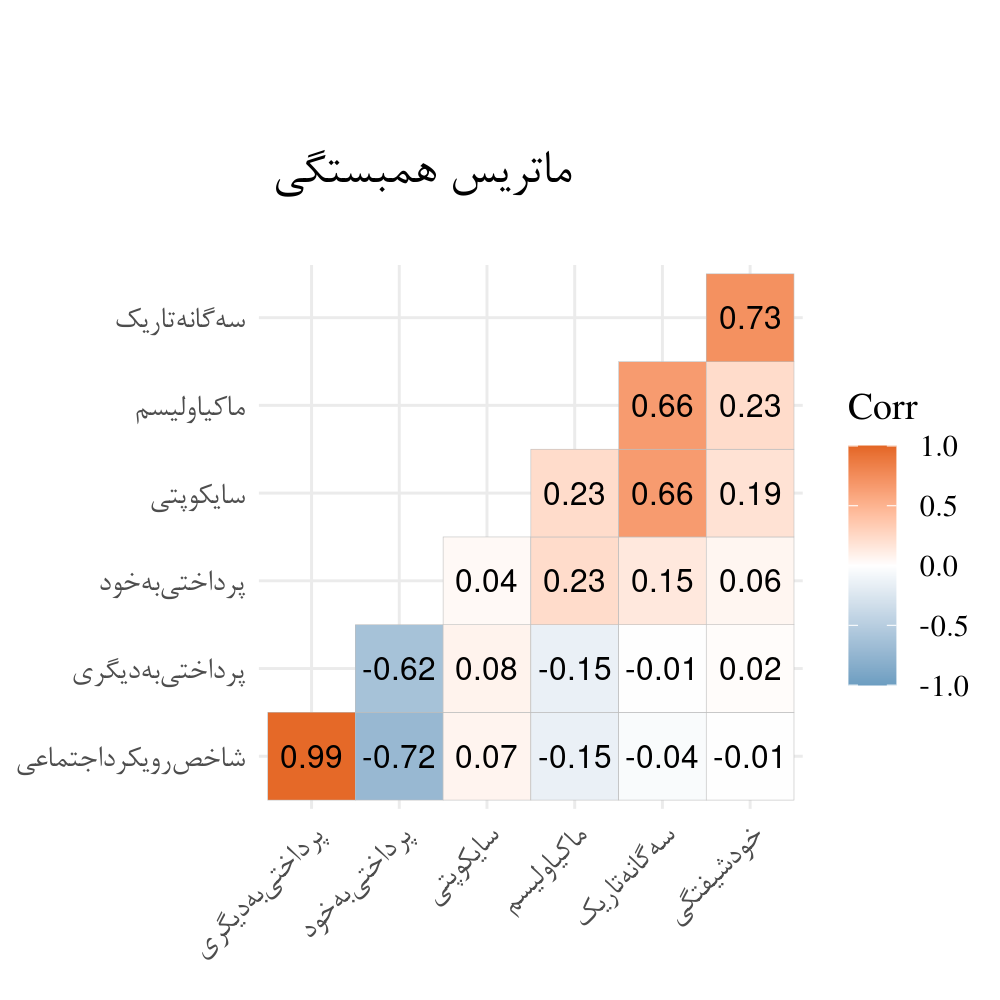

In [36]:
%%R -i CleandDataDFForPlotsIntervalTWithSVONo70 -w 5 -h 5 --units in -r 200
if (!require(corrplot)){install.packages("corrplot")}
if (!require(extrafont)){install.packages("extrafont")}
library(corrplot)
to_fa_numbers = function(x) {
    persian = "\u0660\u0661\u0662\u0663\u0664\u0665\u0666\u0667\u0668\u0669\u06F0\u06F1\u06F2\u06F3\u06F4\u06F5\u06F6\u06F7\u06F8\u06F9"
    english = "\U0030\U0031\U0032\U0033\U0034\U0035\U0036\U0037\U0038\U0039\U0030\U0031\U0032\U0033\U0034\U0035\U0036\U0037\U0038\U0039"
    return (chartr(english, persian, x))
}
# font_import(
#   # path = "/home/master/font/PersianPagerNumber-Regular.ttf", # I placed only the downloaded ttf file here so only the relevant font is imported
#   path = "./font", # I placed only the downloaded ttf file here so only the relevant font is imported
#   recursive = TRUE,
#   prompt = FALSE
#   # pattern = 'Persian Pager Number'
# )

M = cor(CleandDataDFForPlotsIntervalTWithSVONo70)
# p.mat <- cor_pmat(M)
colour_set = colorRampPalette(colors=c("#6D9EC1", "white", "#E46726"))

# pdf(file = "../img/CorrPlotIntervals.pdf")

quartz()
CorrPlotIntervals = {
    ggcorrplot(M, hc.order=TRUE, type="lower", lab=TRUE,
               colors=c("#6D9EC1", "white", "#E46726"),
               title="\n\n ماتریس همبستگی \n", lab_size=4) +
    theme(text=element_text(size=16,  family="Nazli"))
    # recordPlot()
}
# print(CorrPlotIntervals)
# dev.off()
ggsave(filename="../img/CorrPlotIntervals.png",
       plot=print(CorrPlotIntervals),
       device="png")

#  theme(text=element_text(size=16,  family="Persian Pager Number"))

# corrplot(M, tl.col = "blue", bg = "White", tl.srt = 35,
#          title = "\n\n ماتریس همبستگی \n",
#          addCoef.col = "black", type = "full",
#          col = colour_set(100))


In [37]:
# %%R -i RDataFrameTestGroups -w 5 -h 5 --units in -r 200
# # if(!require(xtable)){install.packages("xtable")}
# if(!require(Hmisc)){install.packages("Hmisc")}

# library(xtable)
# library(Hmisc)
# corstarsl <- function(x){
#   require(Hmisc)
#   x <- as.matrix(x)
#   R <- rcorr(x)$r
#   p <- rcorr(x)$P

#   ## define notions for significance levels; spacing is important.
#   mystars <- ifelse(p < .001, "***", ifelse(p < .01, "** ", ifelse(p < .05, "* ", " ")))

#   ## trunctuate the matrix that holds the correlations to two decimal
#   R <- format(round(cbind(rep(-1.11, ncol(x)), R), 2))[,-1]

#   ## build a new matrix that includes the correlations with their apropriate stars
#   Rnew <- matrix(paste(R, mystars, sep=""), ncol=ncol(x))
#   diag(Rnew) <- paste(diag(R), " ", sep="")
#   rownames(Rnew) <- colnames(x)
#   colnames(Rnew) <- paste(colnames(x), "", sep="")

#   ## remove upper triangle
#   Rnew <- as.matrix(Rnew)
#   Rnew[upper.tri(Rnew, diag = TRUE)] <- ""
#   Rnew <- as.data.frame(Rnew)

#   ## remove last column and return the matrix (which is now a data frame)
#   Rnew <- cbind(Rnew[1:length(Rnew)-1])
#   return(Rnew)
# }

# corstarsl(swiss[,1:4])
# xtable(corstarsl(swiss[,1:4])) #Latex code


Mosaic Save


In [38]:
# mosaic(AssessInformationStatsAndPlots[a])
# mosaic(AssessInformationStatsAndPlotsMatrix)
# OddRatio, PValue = fisher_exact(AssessInformationStatsAndPlotsMatrix)
# print('odd ratio is : ' + str(OddRatio))
# print('PValue is : ' + str(PValue))
# OddRatio, PValue = fisher_exact(AssessInformationStatsAndPlots[a])
# print('odd ratio is : ' + str(OddRatio))
# print('PValue is : ' + str(PValue))
#  ! #########

#  ! #########

# plt.show()


Effect and Response Variables 14 Sept 21:36 0001


In [39]:


# (CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['selfFamilyName'].notnull()]
#           [CleandDataDF['selfName'].notnull()]
#           [CleandDataDF['selfPhoneNumber'].notnull()]['selfFamilyName'])

# CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherFamilyName'].notnull()]


In [40]:

#           [CleandDataDF['otherName'].notnull()]
#           [CleandDataDF['otherPhoneNumber'].notnull()]['otherFamilyName']

# print('selfEmailAddress',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['selfEmailAddressRevised1'].notnull()]))
# # ! ########################
# print('selfFamilyNameRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['selfFamilyNameRevised'].notnull()]))
# print('selfNameRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['selfNameRevised'].notnull()]))
# print('selfPhoneNumberRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['selfPhoneNumberRevised'].notnull()]))
# print('selfTelegramIDRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['selfTelegramIDRevised'].notnull()]))
# # print('otherFamilyNameRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherFamilyNameRevised'].notnull()]))
# print('otherNameRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherNameRevised'].notnull()]))
# print('otherPhoneNumberRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherPhoneNumberRevised'].notnull()]))
# # print('otherEmailAddressRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherEmailAddressRevised'].notnull()]))
# print('otherTelegramIDRevised',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherTelegramIDRevised'].notnull()]))

# # ! ########################
# print('otherEmailAddress',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherEmailAddress'].notnull()]))
# print('otherFamilyName',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherFamilyName'].notnull()]))
# print('otherName',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherName'].notnull()]))
# print('otherPhoneNumber',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherPhoneNumber'].notnull()]))
# print('otherTelegramID',len(CleandDataDF[CleandDataDF['Age'] != None][CleandDataDF['otherTelegramID'].notnull()]))
# selfTelegramIDRevised
# otherEmailAddressRevised
# selfEmailAddressRevised1
# selfEmailAddressRevised2


In [41]:
# rank some or t-test


In [42]:
# error bar


In [43]:
# ficsher exact


Variable Generation

In [44]:


Variables = {1: {'variableName': 'InitialSampleSize', 'variableValue': InitialSampleSize},
             2: {'variableName': 'SampleSizeMale', 'variableValue': SampleSizeMale},
             3: {'variableName': 'SampleSizeFemale', 'variableValue': SampleSizeFemale},
             4: {'variableName': 'sampleAgeMeanMale', 'variableValue': sampleAgeMeanMale},
             5: {'variableName': 'sampleAgeSDFemale', 'variableValue': sampleAgeSDFemale},
             5: {'variableName': 'sampleAgeSDMale', 'variableValue': sampleAgeSDMale},
             5: {'variableName': 'sampleAgeSD', 'variableValue': sampleAgeSD},
             6: {'variableName': 'ageMax', 'variableValue': ageMax},
             7: {'variableName': 'ageMin', 'variableValue': ageMin},
             8: {'variableName': 'ageMaxMale', 'variableValue': ageMaxMale},
             9: {'variableName': 'ageMinFemale', 'variableValue': ageMinFemale},
             10: {'variableName': 'CleanedSampleSize', 'variableValue': CleanedSampleSize},
             11: {'variableName': 'sampleAgeMean', 'variableValue': sampleAgeMean},
             12: {'variableName': 'noOfIndividualisticParticipants', 'variableValue': noOfIndividualisticParticipants},
             13: {'variableName': 'noOfCompetitiveParticipants', 'variableValue': noOfCompetitiveParticipants},
             14: {'variableName': 'noOfCooperativeParticipants', 'variableValue': noOfProsocialParticipants},
             15: {'variableName': 'noOfAltruisticParticipants', 'variableValue': noOfAltruisticParticipants},
             16: {'variableName': 'meanOfSelfWTPAllTwoParticipantGroupsAllTwoQuestionSection', 'variableValue': meanOfSelfWTPAllTwoParticipantGroupsAllTwoQuestionSection},
             17: {'variableName': 'SDOfSelfWTPAllTwoParticipantGroupsAllTwoQuestionSection', 'variableValue': SDOfSelfWTPAllTwoParticipantGroupsAllTwoQuestionSection},
             18: {'variableName': 'meanOfOtherWTPAllTwoParticipantGroupsAllTwoQuestionSection', 'variableValue': meanOfOtherWTPAllTwoParticipantGroupsAllTwoQuestionSection},
             19: {'variableName': 'SDOfOtherWTPAllTwoParticipantGroupsAllTwoQuestionSection', 'variableValue': SDOfOtherWTPAllTwoParticipantGroupsAllTwoQuestionSection},
             20: {'variableName': 'PvalueForCorrelationBetweenFirstAndSecondPartOfQuestionsForSelfValuation',
                  'variableValue': PvalueForCorrelationBetweenFirstAndSecondPartOfQuestionsForSelfValuation},
             21: {'variableName': 'PiersonrValueForCorrelationBetweenFirstAndSecondPartOfQuestionsForSelfValuation',
                  'variableValue': PiersonrValueForCorrelationBetweenFirstAndSecondPartOfQuestionsForSelfValuation},
             22: {'variableName': 'PvalueForCorrelationBetweenFirstAndSecondPartOfQuestionsForOtherValuation',
                  'variableValue': PvalueForCorrelationBetweenFirstAndSecondPartOfQuestionsForOtherValuation},
             23: {'variableName': 'PiersonRValueForCorrelationBetweenFirstAndSecondPartOfQuestionsforOtherValuation',
                  'variableValue': PiersonRValueForCorrelationBetweenFirstAndSecondPartOfQuestionsforOtherValuation},
             24: {'variableName': 'meanOfSelfWTPAllTwoParticipantGroupFirstQuestionSection',
                  'variableValue': meanOfSelfWTPAllTwoParticipantGroupFirstQuestionSection},
             25: {'variableName': 'SDOfSelfWTPAllTwoParticipantGroupsFirstQuestionSection',
                  'variableValue': SDOfSelfWTPAllTwoParticipantGroupsFirstQuestionSection},
             26: {'variableName': 'meanOfOtherWTPAllTwoParticipantGroupsSecondQuestionSection',
                  'variableValue': meanOfOtherWTPAllTwoParticipantGroupsSecondQuestionSection},
             27: {'variableName': 'SDOfOtherWTPAllTwoParticipantGroupsSecondQuestionSection',
                  'variableValue': SDOfOtherWTPAllTwoParticipantGroupsSecondQuestionSection},
             28: {'variableName': 'SampleSizeSexualityNoAnswer',
                  'variableValue': SampleSizeSexualityNoAnswer},
             29: {'variableName': 'CleandDataDFForPlotsSize',
                  'variableValue': CleandDataDFForPlotsSize},
             30: {'variableName': 'CleandDataDFForPlotsSizeFemalePlusMale',
                  'variableValue': CleandDataDFForPlotsSizeFemalePlusMale},
             31: {'variableName': 'InitialSampleSizeTotal',
                  'variableValue': InitialSampleSizeTotal},
             32: {'variableName': 'CleandDataDFForPlotsMinusBogusSize',
                  'variableValue': CleandDataDFForPlotsMinusBogusSize},
             33: {'variableName': 'ExitExpSize',
                  'variableValue': ExitExpSize},
             34: {'variableName': 'ContinueExpSize',
                  'variableValue': ContinueExpSize},
             35: {'variableName': 'ValidParticipantsWithBogusPhoneSize',
                  'variableValue': ValidParticipantsWithBogusPhoneSize},
             36: {'variableName': f'{SubmitIndicatorsShort[0]}Drops',
                  'variableValue': PageNotSubmited[SubmitIndicatorsShort[0]]},
             37: {'variableName': f'{SubmitIndicatorsShort[1]}Drops',
                  'variableValue': PageNotSubmited[SubmitIndicatorsShort[1]]},
             }
VariableKeysToExport = ['DarkTriadScore_SampleMean',
                        'DarkTriadScore_SampleSD',
                        'DarkTriadMacScore_SampleMean',
                        'DarkTriadMacScore_SampleSD',
                        'DarkTriadPsyScore_SampleMean',
                        'DarkTriadPsyScore_SampleSD',
                        'DarkTriadNarsScore_SampleMean',
                        'DarkTriadNarsScore_SampleSD']
# for VarKey, index in zip(VariableKeysToExport, range(len(VariableKeysToExport))):
#     Variables = {**Variables,
#                  len(Variables)+1+index: {'variableName': VarKey,
#                                           'variableValue': Statistics.loc[VarKey:]}}
#      print(Variables[index])
# Variables
# show(CleandDataDFForPlotsMinusBogus['DarkTriadScore'].dropna())
df = CleandDataDFForPlotsMinusBogus['DarkTriadScore'].dropna()
# import plotly.express as px
# from pandasgui import show
# show(CleandDataDFForPlotsMinusBogus)

# fig = px.histogram(data_frame=df, x='DarkTriadScore', color=None, facet_row
#     =None, facet_col=None, marginal='rug', cumulative=False, )
# show(fig)


Tables


In [51]:
# print(type(Statistics))
from jinja2 import Template
latex_jinja_env = jinja2.Environment(
    block_start_string='\BLOCK{',
    block_end_string='}',
    variable_start_string='\VAR{',
    variable_end_string='}',
    comment_start_string='\#{',
    comment_end_string='}',
    line_statement_prefix='%%',
    line_comment_prefix='%#',
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath('.'))
)
latex_jinja_env_tables = jinja2.Environment(
    block_start_string='\BLOCK{',
    block_end_string='}',
    variable_start_string='\VAR{',
    variable_end_string='}',
    comment_start_string='\#{',
    comment_end_string='}',
    line_statement_prefix='%%',
    line_comment_prefix='%#',
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath('.'))
)
latex_jinja_env_DF_tables = jinja2.Environment(
    block_start_string='\BLOCK{',
    block_end_string='}',
    variable_start_string='\VAR{',
    variable_end_string='}',
    comment_start_string='\#{',
    comment_end_string='}',
    line_statement_prefix='%%',
    line_comment_prefix='%#',
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath('.'))
)

latex_jinja_env_costume_tables = jinja2.Environment(
    block_start_string='\BLOCK{',
    block_end_string='}',
    variable_start_string='\VAR{',
    variable_end_string='}',
    comment_start_string='\#{',
    comment_end_string='}',
    line_statement_prefix='%%',
    line_comment_prefix='%#',
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath('.'))
)

StatisticsTemp = pd.DataFrame()
StatisticsTemp = Statistics
#  ^ ######################
cidx = pd.MultiIndex.from_arrays([
    ["Equity", "Equity", "Equity", "Equity",
     "Stats", "Stats", "Stats", "Stats", "Rating"],
    ["Energy", "Energy", "Consumer", "Consumer", "", "", "", "", ""],
    ["BP", "Shell", "H&M", "Unilever",
     "Std Dev", "Variance", "52w High", "52w Low", ""]
])
iidx = pd.MultiIndex.from_arrays([
    ["Equity", "Equity", "Equity", "Equity"],
    ["Energy", "Energy", "Consumer", "Consumer"],
    ["BP", "Shell", "H&M", "Unilever"]
])
StylingDataFrame = pd.DataFrame([
    [1, 0.8, 0.66, 0.72, 32.1678, 32.1678**2, 335.12, 240.89, "Buy"],
    [0.8, 1.0, 0.69, 0.79, 1.876, 1.876**2, 14.12, 19.78, "Hold"],
    [0.66, 0.69, 1.0, 0.86, 7, 7**2, 210.9, 140.6, "Buy"],
    [0.72, 0.79, 0.86, 1.0, 213.76, 213.76**2, 2807, 3678, "Sell"],
], columns=cidx, index=iidx)
display(StylingDataFrame)
# styler = ('$' + StylingDataFrame.astype(str)  + '$').style

# print(StylingDataFrame.apply(lambda x: "{}{}{}".format('\$', .astype(str),'\$'),inplace=True))
# styler = StylingDataFrame.style.format({:lambda x:'({:.3f})***'.format(x)})
styler = StylingDataFrame.style

styler.format(subset="Equity", precision=2).format(
    subset="Stats", precision=1, thousands=",").format(
        subset="Rating", formatter=str.upper).format_index(
            escape="latex", axis=1).format_index(
                escape="latex", axis=0).hide(level=0, axis=0)


def rating_color(v):
    if v == "Buy":
        color = "#33ff85"
    elif v == "Sell":
        color = "#ff5933"
    else:
        color = "#ffdd33"
    return f"color: {color}; font-weight: bold;"


styler.background_gradient(cmap="inferno", subset="Equity", vmin=0, vmax=1).applymap(
    rating_color, subset="Rating")
styler.applymap_index(
    lambda v: "rotatebox:{45}--rwrap--latex;", level=2, axis=1)
# StatisticsTableLatexfromDF
StyledTableFromDF = styler.to_latex(
    column_format="llLLLLLLLLl",
    caption="Selected stock correlation and simple statistics.",
    clines="skip-last;data",
    convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True,)
    # escape=False)
DFTables = {1: {'DFTableName': 'StyledTableFromDF',
              'DFTableValue': StyledTableFromDF}}
DFTablesTemplate = latex_jinja_env_tables.get_template(
    './JinjaTemplates/DFTablesJinjaTemplates.tex')
PandasdataFrameTables = DFTablesTemplate.render(
    DFTables=DFTables,  NumebrOfDFTables=len(DFTables))
with open("../tables/PandasdataFrameTables.tex", "w") as output:
    output.write(PandasdataFrameTables)
# StylingDataFrame
# styler



Equity                           Stats           \
                         Energy       Consumer                             
                             BP Shell      H&M Unilever Std Dev Variance   
Equity Energy   BP          1.0   0.8     0.66     0.72 32.1678 1,034.77   
                Shell       0.8   1.0     0.69     0.79   1.876  3.51938   
       Consumer H&M        0.66  0.69      1.0     0.86     7.0     49.0   
                Unilever   0.72  0.79     0.86      1.0  213.76 45,693.3   

                                          Rating  
                                                  
                         52w High 52w Low         
Equity Energy   BP         335.12  240.89    Buy  
                Shell       14.12   19.78   Hold  
       Consumer H&M         210.9   140.6    Buy  
                Unilever  2,807.0 3,678.0   Sell

In [46]:
# Statistics


JINJA


In [47]:


CostumeTablesKeysContents = {}
CostumeTables = {}
# %%capture captured --no-stderr
template = latex_jinja_env.get_template(
    './JinjaTemplates/VariablesJinjaTemplates.tex')
outputTexVariables = template.render(
    Variables=Variables,  NumebrOfVariables=len(Variables))
with open("../tex/variables.tex", "w") as output:
    output.write(outputTexVariables)
TablesTemplate = latex_jinja_env_tables.get_template(
    './JinjaTemplates/TablesJinjaTemplate.tex')
TablesOutputTexVariables = TablesTemplate.render(
    Tables=Tables,  NumebrOfTables=len(Tables))
CustomTablesJinjaUniqueTemplates = latex_jinja_env_costume_tables.get_template(
    './JinjaTemplates/CustomTablesJinjaUniqueTemplates.tex')
CustomTablesJinjaUniqueTemplatesOutputTexVariables = CustomTablesJinjaUniqueTemplates.render(
    DarkTriadScoreFemaleMean=Statistics.loc['DarkTriadScoreFemale', 'Mean'],
    DarkTriadScoreFemaleSD=Statistics.loc['DarkTriadScoreFemale', 'SD'],
    DarkTriadMacScoreFemaleMean=Statistics.loc['DarkTriadMacScoreFemale', 'Mean'],
    DarkTriadMacScoreFemaleSD=Statistics.loc['DarkTriadMacScoreFemale', 'SD'],
    DarkTriadPsyScoreFemaleMean=Statistics.loc['DarkTriadPsyScoreFemale', 'Mean'],
    DarkTriadPsyScoreFemaleSD=Statistics.loc['DarkTriadPsyScoreFemale', 'SD'],
    DarkTriadNarsScoreFemaleMean=Statistics.loc['DarkTriadNarsScoreFemale', 'Mean'],
    DarkTriadNarsScoreFemaleSD=Statistics.loc['DarkTriadNarsScoreFemale', 'SD'],

    DarkTriadScoreMaleMean=Statistics.loc['DarkTriadScoreMale', 'Mean'],
    DarkTriadScoreMaleSD=Statistics.loc['DarkTriadScoreMale', 'SD'],
    DarkTriadMacScoreMaleMean=Statistics.loc['DarkTriadMacScoreMale', 'Mean'],
    DarkTriadMacScoreMaleSD=Statistics.loc['DarkTriadMacScoreMale', 'SD'],
    DarkTriadPsyScoreMaleMean=Statistics.loc['DarkTriadPsyScoreMale', 'Mean'],
    DarkTriadPsyScoreMaleSD=Statistics.loc['DarkTriadPsyScoreMale', 'SD'],
    DarkTriadNarsScoreMaleMean=Statistics.loc['DarkTriadNarsScoreMale', 'Mean'],
    DarkTriadNarsScoreMaleSD=Statistics.loc['DarkTriadNarsScoreMale', 'SD'],
)
with open("../tables/customtables.tex", "w") as output:
    output.write(CustomTablesJinjaUniqueTemplatesOutputTexVariables)


NameError: name 'Tables' is not defined

In [ ]:


reshaper = arabic_reshaper.ArabicReshaper(
    arabic_reshaper.config_for_true_type_font(
        '../font/IRTitr.ttf',
        arabic_reshaper.ENABLE_ALL_LIGATURES
    )
)


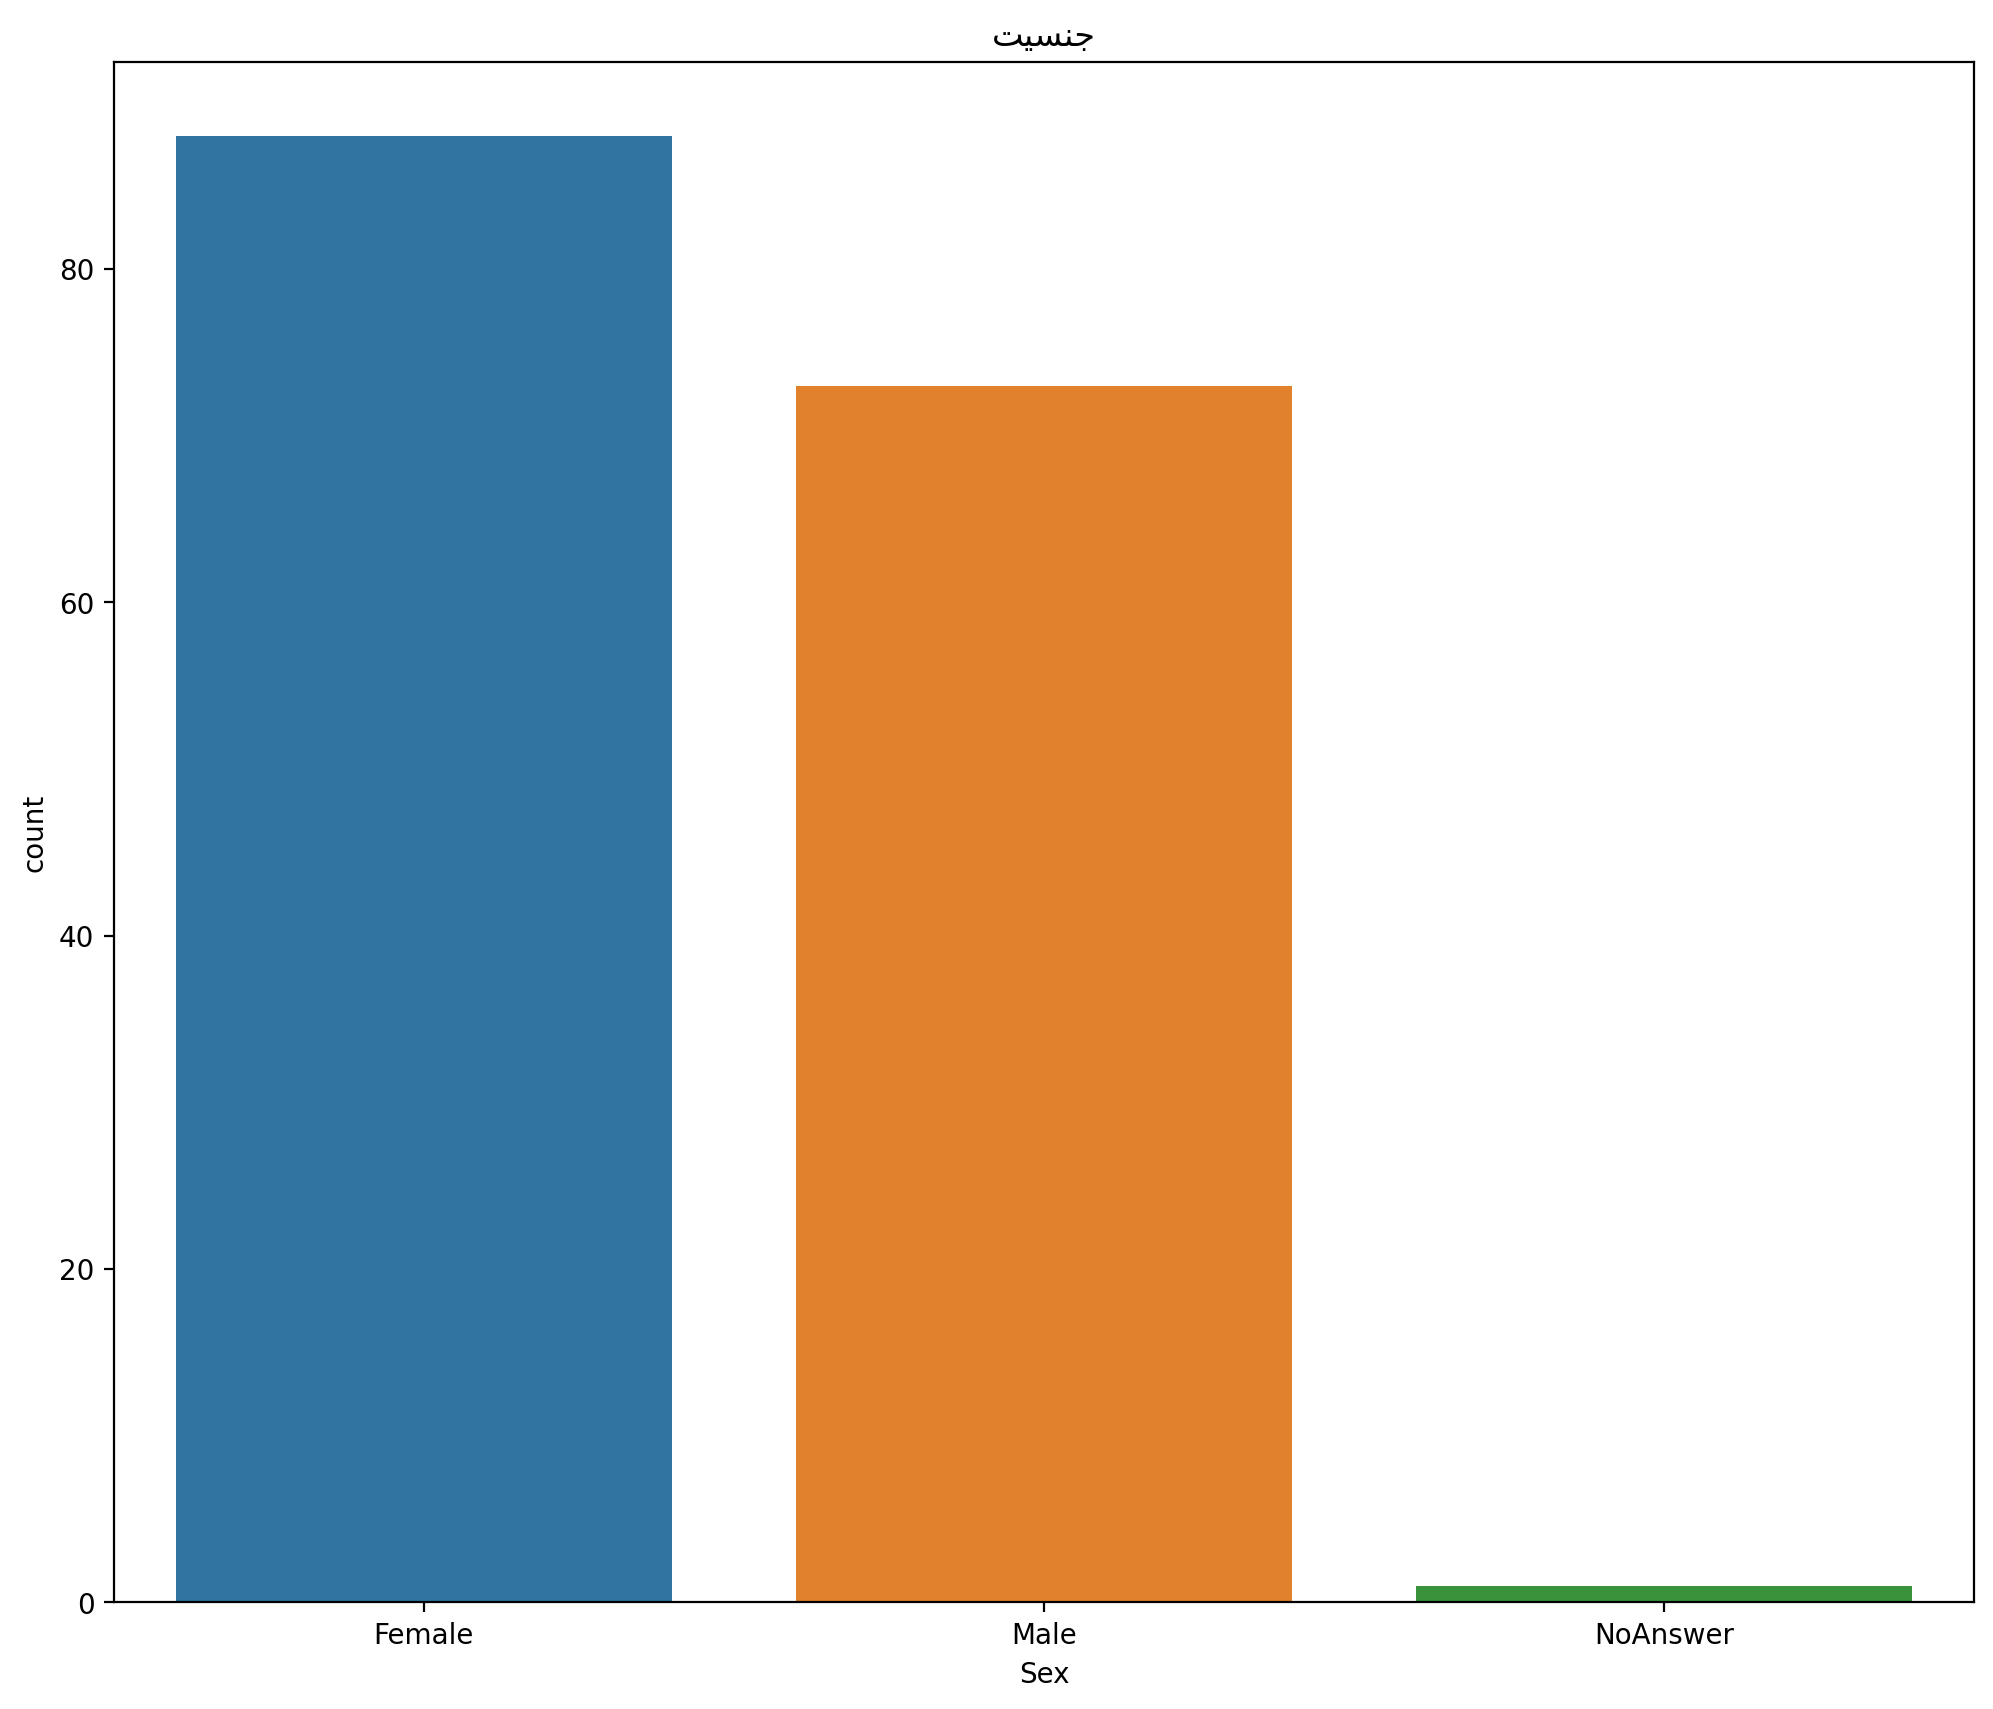

In [ ]:

plt.clf()
PlotDFSex = CleandDataDFForPlotsMinusBogus.copy()
PlotDF = CleandDataDFForPlotsMinusBogus.copy()
PlotDFSex['Sex'] = PlotDF['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion']
SexualityFigPersianTitle = 'جنسیت'
SexualityFigPersianTitlereshaped_text = reshaper.reshape(
    SexualityFigPersianTitle)
SexualityFigPersianTitlebidi_text = get_display(
    SexualityFigPersianTitlereshaped_text)

plt.title(SexualityFigPersianTitlebidi_text, fontsize=12)
sns.countplot(x='Sex', data=PlotDFSex)
plt.savefig('../img/sexualityAgainstPopulation.pdf')
plt.show()
# fig.clear()
# plt.close()


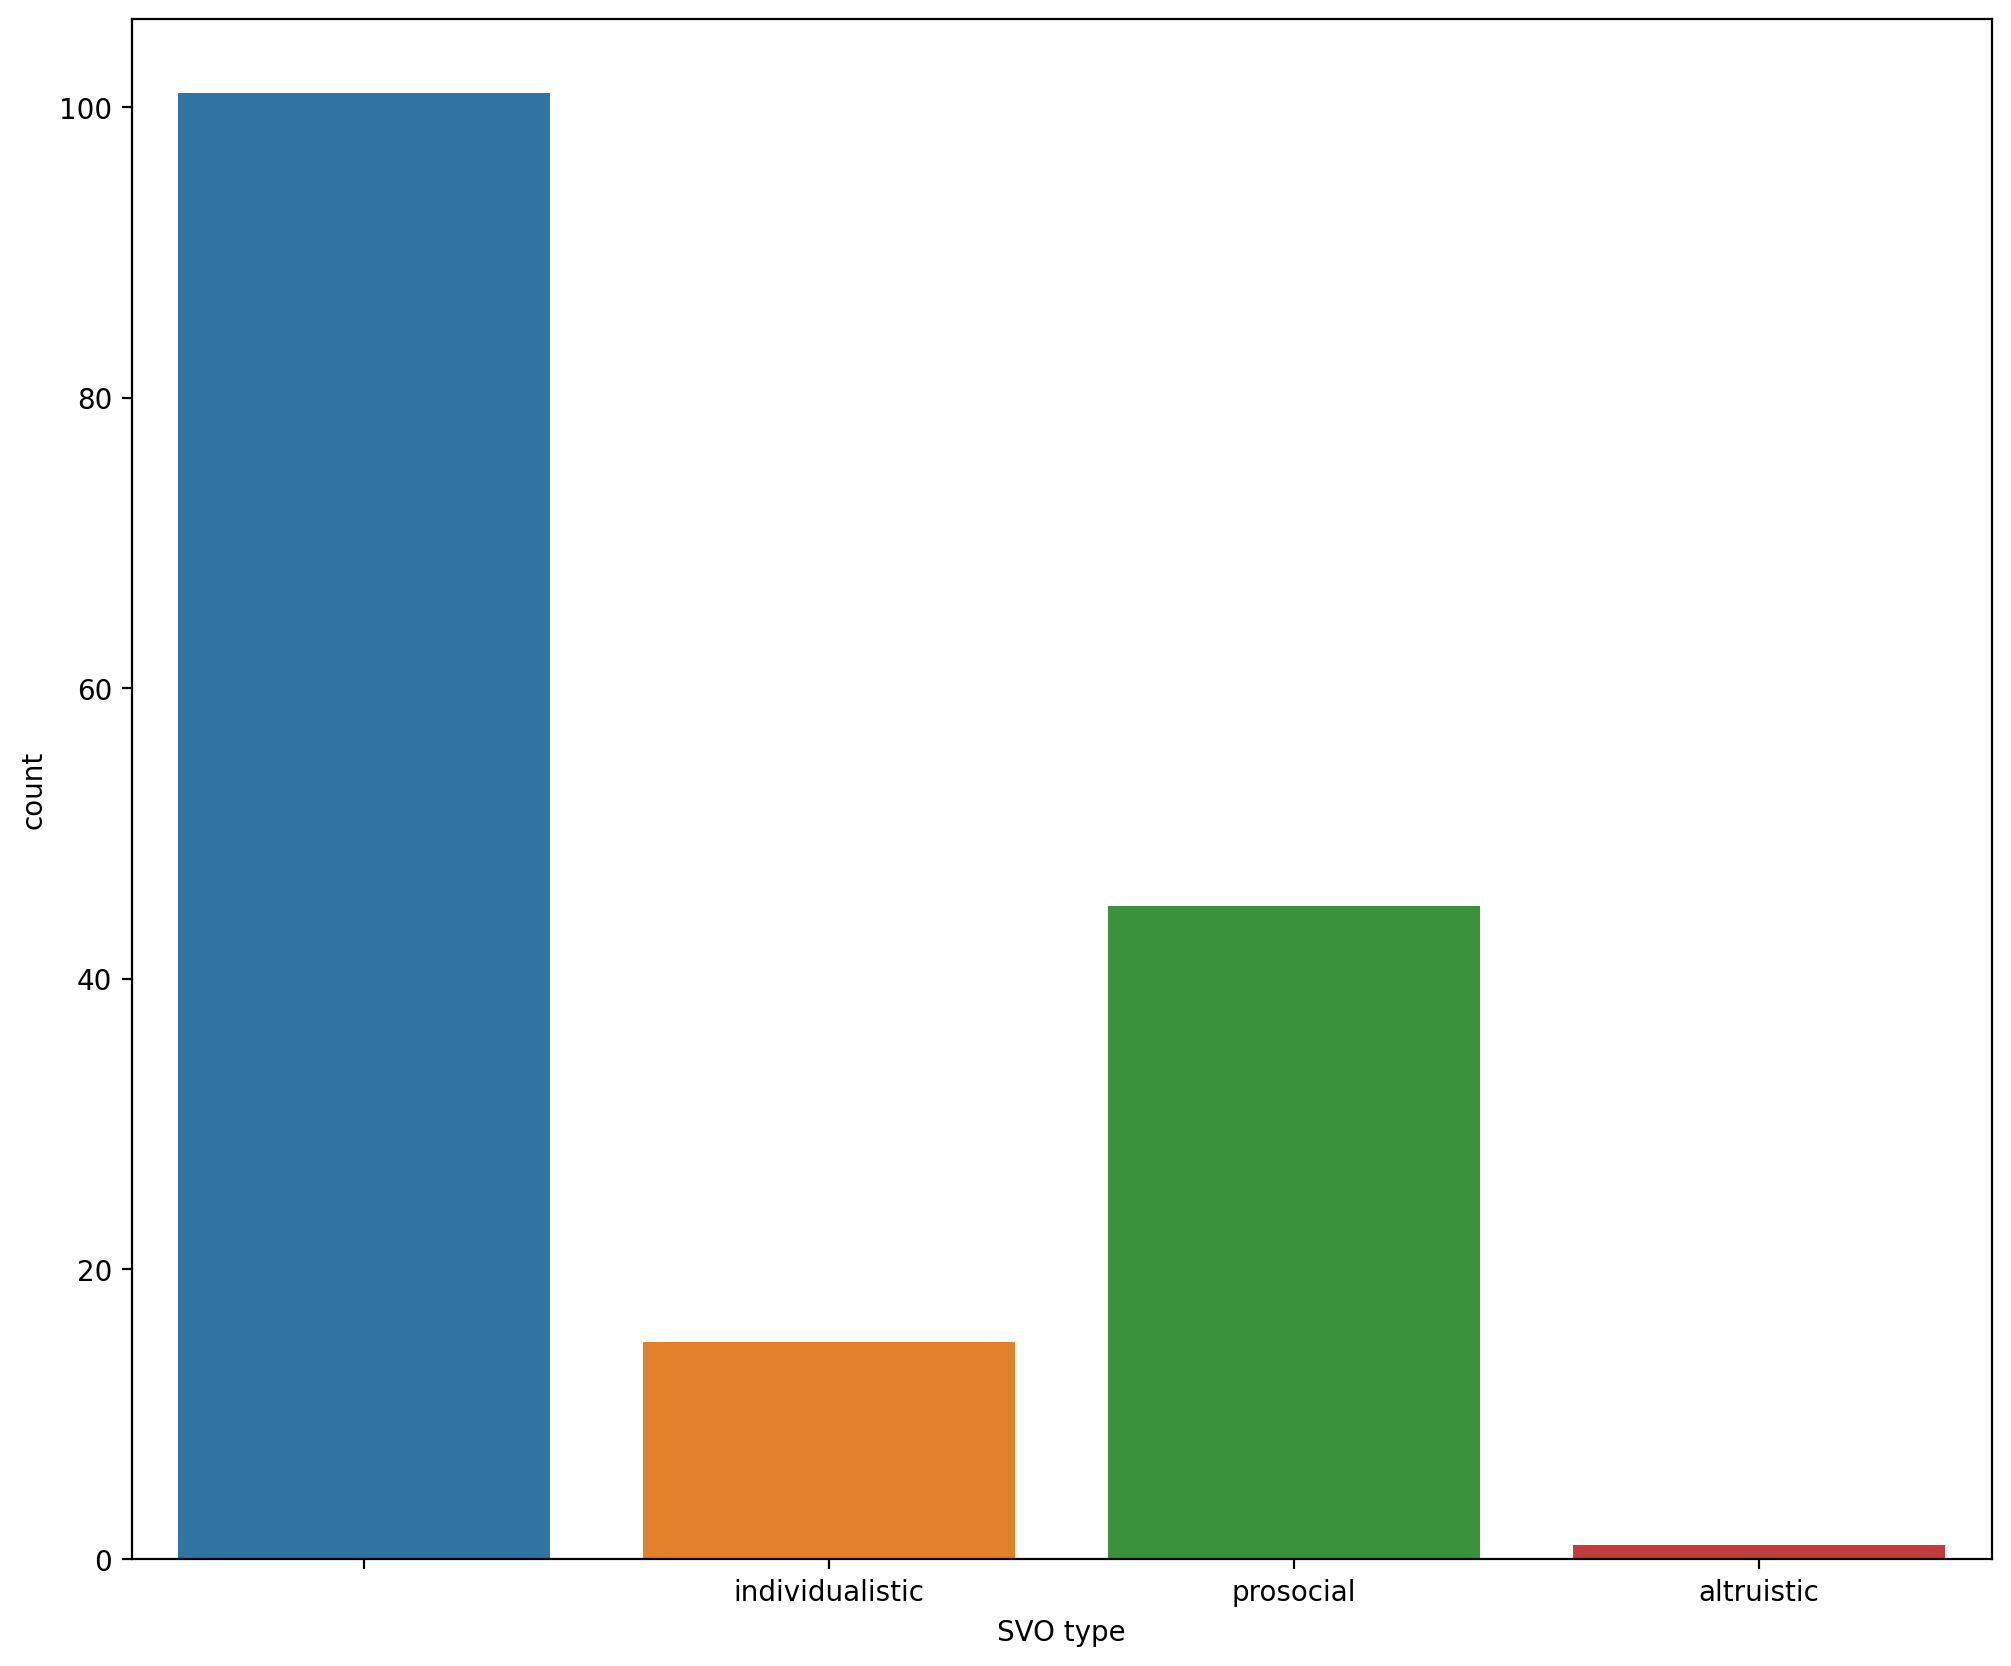

In [ ]:
plt.clf()
# PlotDFSex = CleandDataDFForPlotsMinusBogus.copy()
PlotDF = CleandDataDFForPlotsMinusBogus.copy()

PlotDFSVOSex = CleandDataDFForPlotsMinusBogus.copy().dropna(
    subset=['SVOSliderTest.type'])
PlotDFSVOSex['SVO type'] = PlotDF['SVOSliderTest.type']
# PlotDFSVOSex['SVOScore'] = PlotDF['SVOSliderTest.svo']
PlotDFSVOSex['Sex'] = PlotDF['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion']
# PlotDF
# PlotDFDropedSVONaN = PlotDF.dropna(subset=['SVOSliderTest.type']).copy()
# SexualitySVOFigPersianTitle = 'رویکرد ارزش اجتماعی'
# SexualitySVOFigPersianTitleTitlereshaped_text = arabic_reshaper.reshape(
#     SexualitySVOFigPersianTitle)
# SexualitySVOFigPersianTitlebidi_text = get_display(
#     SexualitySVOFigPersianTitleTitlereshaped_text)
# plt.title(SexualitySVOFigPersianTitlebidi_text, fontsize=12)
# sns.countplot(x='SVO type', hue='Sex', data=PlotDFSVOSex)
sns.countplot(x='SVO type',  data=PlotDFSVOSex)
plt.savefig('../img/sexualityAndSVOAgainstPopulation.pdf')
plt.show()
# fig.clear()
# plt.close()


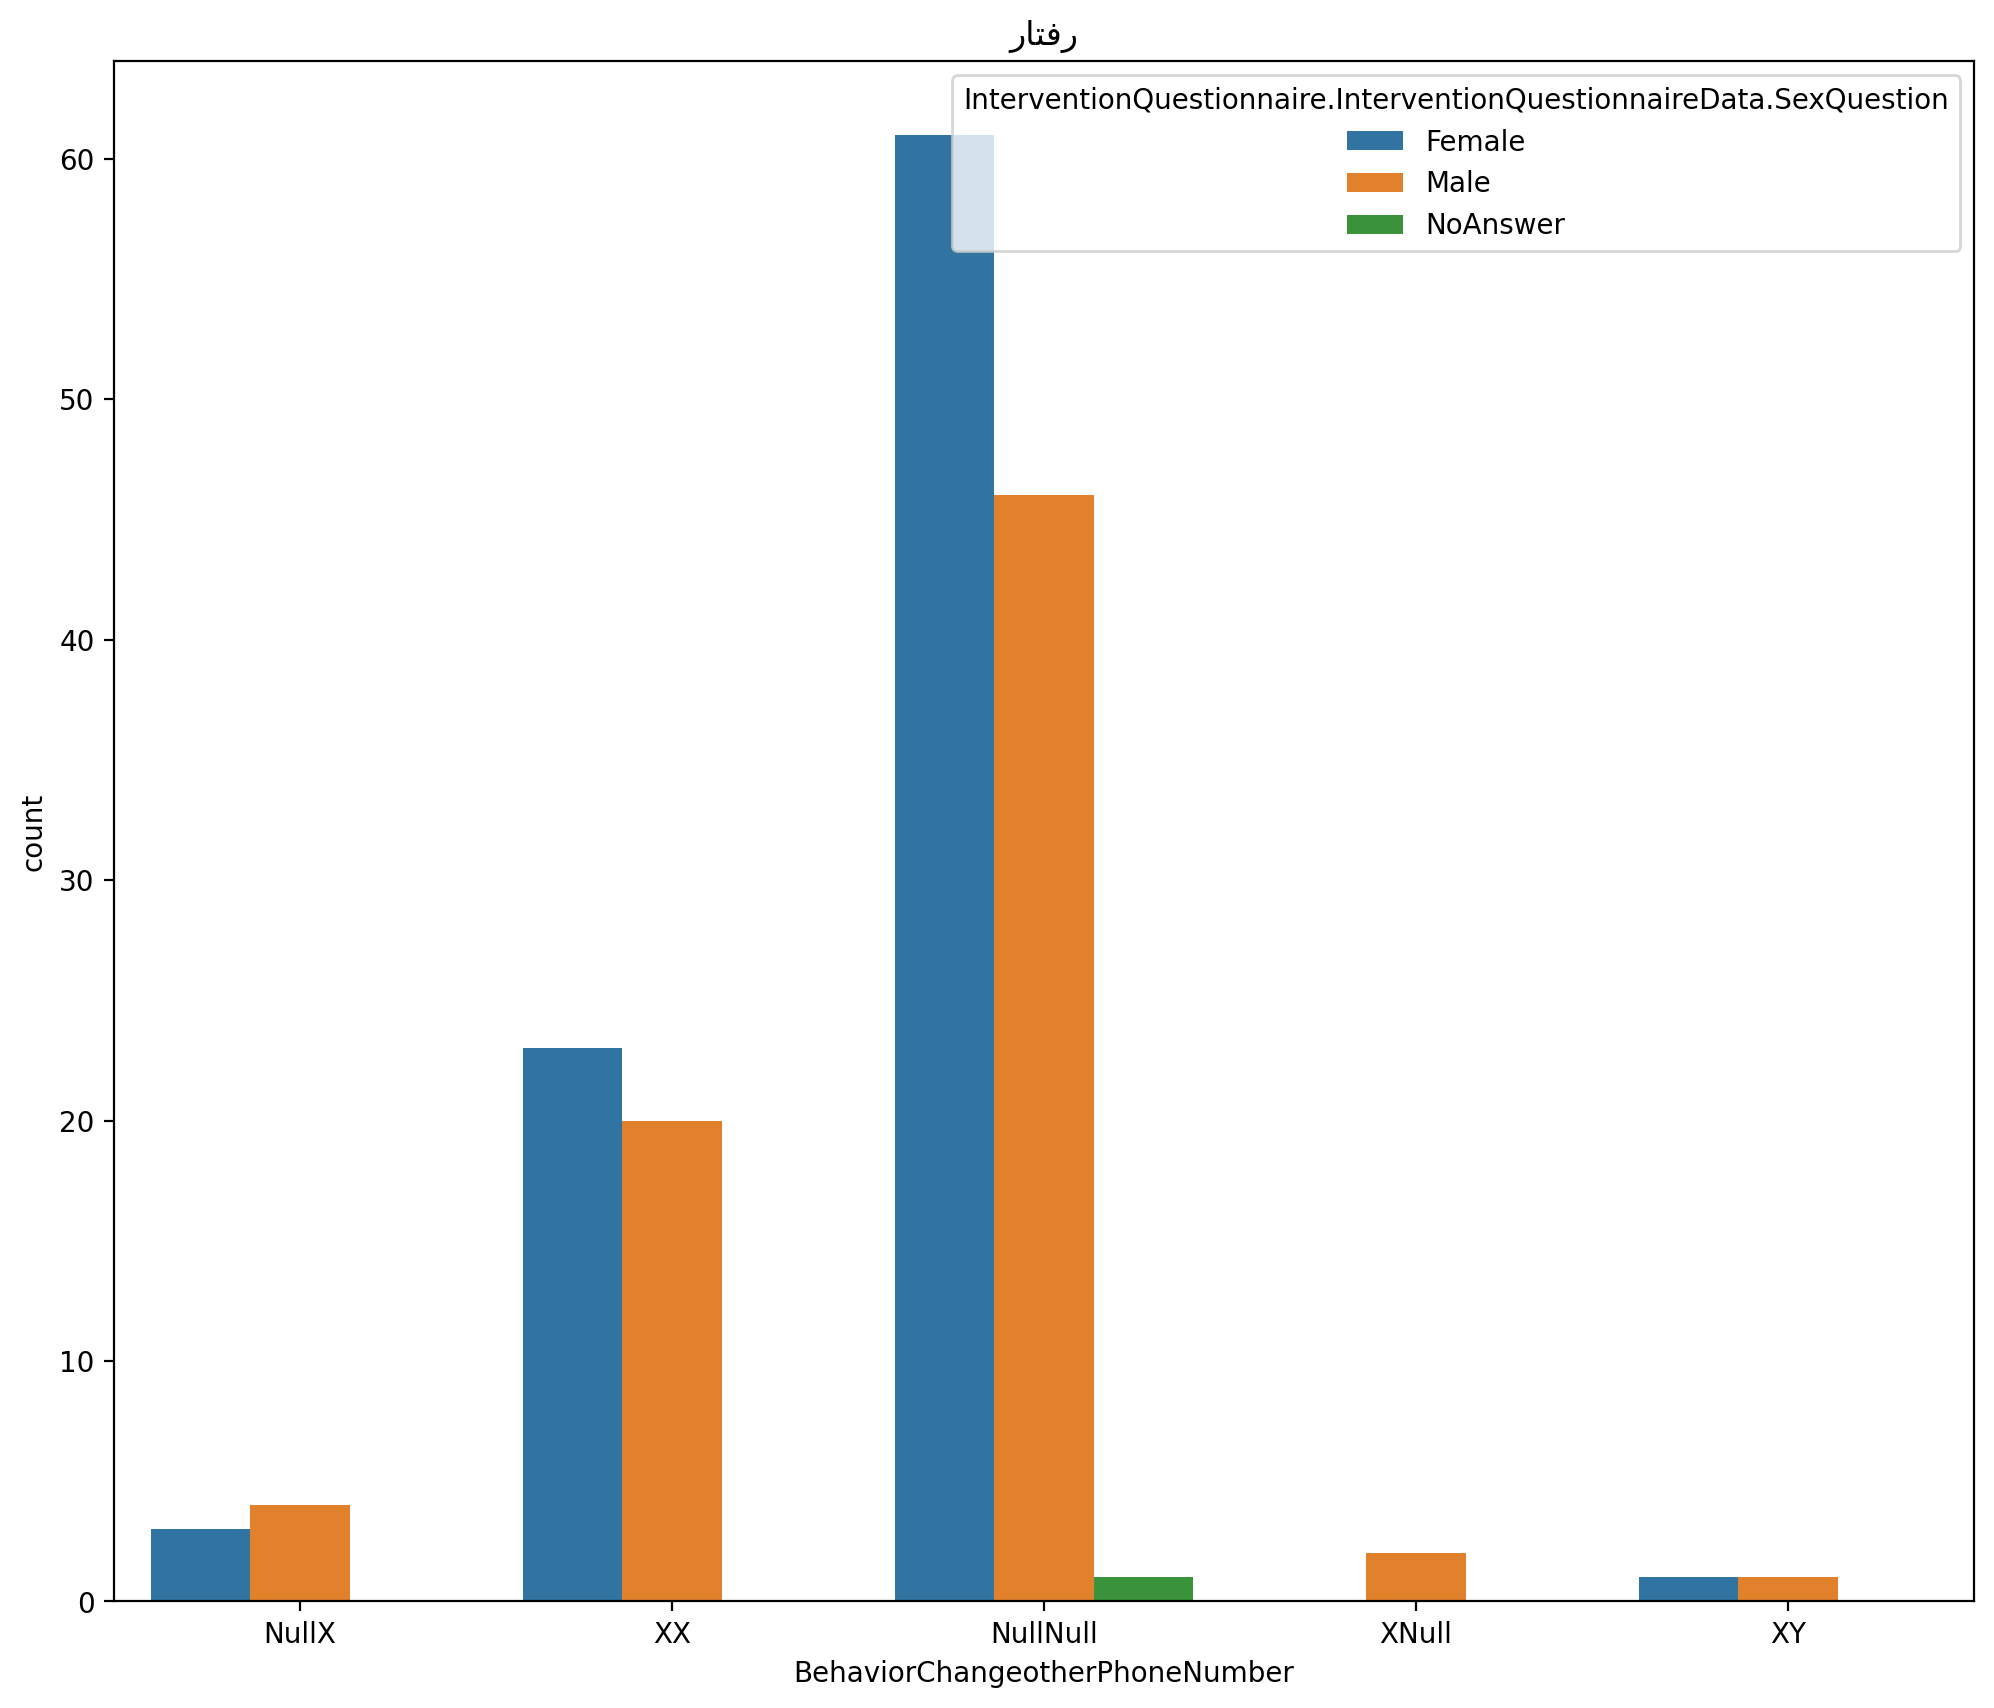

In [ ]:
plt.clf()

PlotDFSex = CleandDataDFForPlotsMinusBogus.copy()
PlotDF = CleandDataDFForPlotsMinusBogus.copy()


# PlotDF
# PlotDFDropedSVONaN = PlotDF.dropna(subset=['SVOSliderTest.type']).copy()

sns.countplot(x='BehaviorChangeotherPhoneNumber',
              hue='InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion', data=EffectResponseDisclosureDF)
SexualitySVOFigPersianTitle = 'رفتار'
SexualitySVOFigPersianTitleTitlereshaped_text = arabic_reshaper.reshape(
    SexualitySVOFigPersianTitle)
SexualitySVOFigPersianTitlebidi_text = get_display(
    SexualitySVOFigPersianTitleTitlereshaped_text)

plt.title(SexualitySVOFigPersianTitlebidi_text, fontsize=12)

plt.savefig('../img/Frequency_Behavior_Phnone_Number.pdf')
plt.show()
# fig.clear()
# plt.close()
# fig.clf()


In [ ]:

plt.clf()

PlotDFSex = CleandDataDFForPlotsMinusBogus.copy()
PlotDF = CleandDataDFForPlotsMinusBogus.copy()

PlotDFSVOSex = CleandDataDFForPlotsMinusBogus.copy().dropna(
    subset=['SVOSliderTest.type'])
PlotDFSVOSex['SVO type'] = PlotDF['SVOSliderTest.type']
# PlotDFSVOSex['SVOScore'] = PlotDF['SVOSliderTest.svo']
PlotDFSVOSex['Sex'] = PlotDF['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion']
# PlotDF
# PlotDFDropedSVONaN = PlotDF.dropna(subset=['SVOSliderTest.type']).copy()
# SexualitySVOFigPersianTitle = 'رویکرد ارزش اجتماعی'
# SexualitySVOFigPersianTitleTitlereshaped_text = arabic_reshaper.reshape(
#     SexualitySVOFigPersianTitle)
# SexualitySVOFigPersianTitlebidi_text = get_display(
#     SexualitySVOFigPersianTitleTitlereshaped_text)
# plt.title(SexualitySVOFigPersianTitlebidi_text, fontsize=12)
# sns.countplot(x='SVO type', hue='Sex', data=PlotDFSVOSex)
sns.countplot(x='SVO type',  hue='Sex',  data=PlotDFSVOSex)

plt.savefig('../img/sexualityAndSVOAgainstPopulation.pdf')


In [ ]:


plt.clf()

# داده های به دترد نخود
# آنهایی که تمت شدند
# چه ویژگی ایی داشته اند
# چه کساتنی
# PlotDF.rename(columns = {'SVOSliderTest.type':'SVO type'}, inplace = True)
PlotDFDTR = CleandDataDFForPlotsMinusBogus.copy()
PlotDFDTR['Sex'] = PlotDFDTR['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion']
SexualitySVOFigPersianTitle = 'نمودار هیستوگرام سه‌گانه تاریک'
SexualitySVOFigPersianTitleTitlereshaped_text = arabic_reshaper.reshape(
    SexualitySVOFigPersianTitle)
SexualitySVOFigPersianTitlebidi_text = get_display(
    SexualitySVOFigPersianTitleTitlereshaped_text)
var02_1 = 'نمره سه‌گانه تاریک'
var02_2 = arabic_reshaper.reshape(var02_1)
var02_3 = get_display(var02_2)
var03_1 = 'فراوانی'
var03_2 = arabic_reshaper.reshape(var03_1)
var03_3 = get_display(var03_2)

plt.title(SexualitySVOFigPersianTitlebidi_text, fontsize=12)
bins = list(range(0, 50, 5))
plt.hist((PlotDFDTR['DarkTriadScore'].dropna()), bins,
         facecolor='r', alpha=0.7, edgecolor='k', linewidth=1)

# plt.xlabel("DarkTriadScore")
plt.xlabel(var02_3)
plt.ylabel(var03_3)
# sns.countplot(x='DarkTriadScore',data=PlotDF)
plt.savefig('../img/SexToDTR.pdf')
# plt.show()
# fig.clear()
plt.close()
plt.clf()


In [ ]:

def ShortenningVars(InputVars):
    OutputVars = []
    for Tag in InputVars:
        ShortVar = Tag.split(".", -1)[-1].replace('-', '')
        OutputVars.append(ShortVar)
    return OutputVars


In [ ]:
EffectResponseDisclosureDFToRename = EffectResponseDisclosureDF.copy()
EffectAndResponseKeysToRename = [
    'LandingPage.submittime',
    'Assessment.Assessment.ExperimentGroup',
    'Assessment.Assessment.ReceiveOtherResultsRequest',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherNameRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherFamilyNameRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther.otherPhoneNumberRevised',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherNameRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherFamilyNameRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther01.otherPhoneNumberRevised01',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherNameRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherFamilyNameRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther02.otherPhoneNumberRevised02',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherNameRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherFamilyNameRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther03.otherPhoneNumberRevised03',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherNameRevised04',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherFamilyNameRevised04',
    'Assessment.Assessment.SelfANDOtherPIIInformationOther04.otherPhoneNumberRevised04',
    'InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.AuctionsAgreement',
    'InterventionQuestionnaire.InterventionQuestionnaireData.CityName',
    'InterventionQuestionnaire.InterventionQuestionnaireData.EducationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.InformationQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.JobSatisfaction',
    'InterventionQuestionnaire.InterventionQuestionnaireData.JobTitle',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MajorForEducation',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MajorNameForOther',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MentalHealthQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.MoneyQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.RelationshipStatus',
    'InterventionQuestionnaire.InterventionQuestionnaireData.SaftyInLifeQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.SexLifeQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion',
    'InterventionQuestionnaire.InterventionQuestionnaireData.TotalQualityOfLife',
    'InterventionQuestionnaire.InterventionQuestionnaireData.UniversityName',
    'InterventionQuestionnaire.InterventionQuestionnaireData.ImportanceOfScience',
    'InterventionQuestionnaire.InterventionQuestionnaireData.DataScieneFamiliarity',
    'SVOSliderTest.svo',
    'SVOSliderTest.type',
    'SVOSliderTest.isConsistent',
    'SVOSliderTest.selfTotal',
    'SVOSliderTest.otherTotal',
    'darktriad.darktriadsurvey.DTriad01Mac01',
    'darktriad.darktriadsurvey.DTriad02Mac02',
    'darktriad.darktriadsurvey.DTriad03Mac03',
    'darktriad.darktriadsurvey.DTriad04Mac04',
    'darktriad.darktriadsurvey.DTriad05Psy01',
    'darktriad.darktriadsurvey.DTriad06Psy02',
    'darktriad.darktriadsurvey.DTriad07Psy03',
    'darktriad.darktriadsurvey.DTriad08Psy04',
    'darktriad.darktriadsurvey.DTriad09Nars01',
    'darktriad.darktriadsurvey.DTriad10Nars02',
    'darktriad.darktriadsurvey.DTriad11Nars03',
    'darktriad.darktriadsurvey.DTriad12Nars04',
    'darktriad.isReversed',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidCareerRelatedPrivacy02',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidFreedomRelatedPrivacy02',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPhysicalPrivacy02',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidProsecutionRelatedPrivacy02',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidPsychologicalPrivacy02',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidResourceRelatedPrivacy02',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy01',
    'willingnessToPayOthers.willingnessToPayOthersData.AGMPBidSocialPrivacy02',
    'willingnessToPayOthers.attitudeGroupName',
    'willingnessToPayOthers.attitudeisReversed',
    'willingnessToPayOthers.normGroupName',
    'willingnessToPayOthers.normisReversed',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-Attitude',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-AttitudeImportance',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-BehaviorQuestion',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IdentificationwiththeReferent',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-IntentionQuestion',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-PerceivedBehavioralControlQuestion',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestion',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionContext',
    'TPBQuestionnaire.TPBQuestionnaireData.TPBQuestionnaire-SubjectiveNormQuestionExpert',
]
CountPlotsForResponseVriables = ShortenningVars([
    *CountDisclosures, 'BehaviorChangeotherPhoneNumber'])
CountPlotsForEffectVariables = ShortenningVars([
    *LabelsUsualSuspectsValidityReliblity,
    *LabelsUsualSuspectsOrdinalTPB,
    *LabelsUsualSuspectsNominalBooleanTPB,
    *LabelsUsualSuspectsOrdinal,
    *LabelsUsualSuspectsNominalExperimentalIntervention,
    *LabelsUsualSuspectsNominalBoolean,
    *LabelsUsualSuspectsNominal
])
EffectAndResponseKeysRenamed = ShortenningVars(EffectAndResponseKeysToRename)

for Tag in EffectAndResponseKeysToRename:
    ShortCol = Tag.split(".", -1)[-1].replace('-', '')
    EffectResponseDisclosureDFToRename.rename(
        columns={Tag: ShortCol}, inplace=True)


#
# print(EffectResponseDisclosureDFToRename.loc[:,'ExperimentGroup'])
EffectResponseDisclosureDFToRename.loc[:, 'ExperimentGroup'] = [
    i[0] for i in EffectResponseDisclosureDFToRename.loc[:, 'ExperimentGroup']]
# print(EffectResponseDisclosureDFToRename.loc[:,'ExperimentGroup'])
# EffectAndResponseKeysRenamed


In [ ]:
import pandas as pd
# from plotnine import *
# from plotnine.data import mtcars
# from plotnine.ggplot import save_as_pdf_pages
# sns.countplot(x='BehaviorChangeotherPhoneNumber',
#  hue='InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion', data=EffectResponseDisclosureDF)


def combine(counts, percentages):
    fmt = '{} ({:.1f}%)'.format
    return [fmt(c, p) for c, p in zip(counts, percentages)]


In [ ]:
# %%R -i SVOAndDTRNaNDroped -w 5 -h 5 --units in -r 200
# theme_set(theme_void())
# theme_set(theme_minimal())
# theme_set(theme_dark())

# def facet_pages01():
#     for CountPlotsForEffectVariable in CountPlotsForEffectVariables:
#         for CountPlotsForResponseVriable in CountPlotsForResponseVriables:
#             Factor01 = CountPlotsForResponseVriable
#             Factor02 = CountPlotsForEffectVariable
#             # if Factor01 == 'ReceiveOtherResultsRequest' or Factor02 == 'ReceiveOtherResultsRequest' or Factor01 == 'WaitingRoom' or Factor02 == 'WaitingRoom':
#             #     continue
#             try:
#                 if Factor01 == 'ReceiveOtherResultsRequest' or Factor02 == 'ReceiveOtherResultsRequest' or Factor01 == 'WaitingRoom' or Factor02 == 'WaitingRoom':
#                     continue
#                 yield (ggplot(EffectResponseDisclosureDFToRename, aes(f'factor({Factor01})', fill=f'factor({Factor02})'))
#                     + geom_bar()
#                 #  + geom_text(
#                 #      aes(label=after_stat('count')),
#                 #      stat='count',
#                 #      nudge_x=-0.14,
#                 #      nudge_y=0.125,
#                 #      va='bottom'
#                 #  )
#                 #  + geom_text(
#                 #      aes(label=after_stat('prop*100'), group=1),
#                 #      stat='count',
#                 #      nudge_x=0.14,
#                 #      nudge_y=0.125,
#                 #      va='bottom',
#                 #      format_string='({:.1f}%)'
#                 #  )
#                     + geom_text(
#                     aes(label=after_stat('combine(count, prop*100)'), group=1),
#                     stat='count',
#                     nudge_y=0.125,
#                     va='bottom'
#                 )
#                 )
#             except GeneratorExit:
#                 print(f'Factor01{Factor01},Factor02{Factor02}')
#             except TypeError:
#                 print(f'Type error Factor01: {Factor01},Factor02:{Factor02}')
#             except:
#                 print(f'Type error Factor01: {Factor01},Factor02:{Factor02}')
#             finally:
#                 print(f'Finally Factor01: {Factor01},Factor02: {Factor02}')

# def facet_pages02():
#     for CountPlotsForEffectVariable in CountPlotsForEffectVariables:
#         for CountPlotsForResponseVriable in CountPlotsForResponseVriables:
#             Factor01 = CountPlotsForResponseVriable
#             Factor02 = CountPlotsForEffectVariable
#             # if Factor01 == 'ReceiveOtherResultsRequest' or Factor02 == 'ReceiveOtherResultsRequest' or Factor01 == 'WaitingRoom' or Factor02 == 'WaitingRoom':
#             #     continue
#             def prop_per_x(x, count):
#                 """
#                 Compute the proportion of the counts for each value of x
#                 """
#                 df = pd.DataFrame({
#                     'x': x,
#                     'count': count
#                 })
#                 prop = df['count']/df.groupby('x')['count'].transform('sum')
#                 return prop

#             try:
#                 if Factor01 == 'ReceiveOtherResultsRequest' or Factor02 == 'ReceiveOtherResultsRequest' or Factor01 == 'WaitingRoom' or Factor02 == 'WaitingRoom':
#                     continue
#                 yield (ggplot(EffectResponseDisclosureDFToRename, aes(f'factor({Factor01})', fill=f'factor({Factor02})'))
#                     + geom_bar(position='dodge2')
#                     + geom_text(
#                     aes(
#                         label=after_stat('prop_per_x(x, count) * 100'),
#                         y=stage(after_stat='count', after_scale='y+.25')
#                     ),
#                     stat='count',
#                     position=position_dodge2(width=0.9),
#                     format_string='{:.1f}%',
#                     size=9,
#                 )
#                 )
#             except GeneratorExit:
#                 print(f'Factor01{Factor01},Factor02{Factor02}')
#             except TypeError:
#                 print(f'Type error Factor01: {Factor01},Factor02:{Factor02}')
#             except:
#                 print(f'Type error Factor01: {Factor01},Factor02:{Factor02}')
#             finally:
#                 print(f'Finally Factor01: {Factor01},Factor02: {Factor02}')

# def facet_pages03():
#     for CountPlotsForEffectVariable in CountPlotsForEffectVariables:
#         for CountPlotsForResponseVriable in CountPlotsForResponseVriables:
#             Factor01 = CountPlotsForResponseVriable
#             Factor02 = CountPlotsForEffectVariable
#             try:
#                 if Factor01 == 'ReceiveOtherResultsRequest' or Factor02 == 'ReceiveOtherResultsRequest' or Factor01 == 'WaitingRoom' or Factor02 == 'WaitingRoom':
#                     continue
#                 yield (ggplot(EffectResponseDisclosureDFToRename, aes(f'factor({Factor01})', fill=f'factor({Factor02})'))
#                     + geom_bar(position='fill')
#                     + geom_label(
#                     aes(label=after_stat('prop_per_x(x, count) * 100')),
#                     stat='count',
#                     position='fill',
#                     format_string='{:.1f}%',
#                     size=9,
#                 )
#                     #   + geom_text(
#                     #      aes(label=after_stat('count'), group=1),
#                     #      stat='count',
#                     #      nudge_y=0.125,
#                     #      va='bottom'
#                     #  )
#                 )

#             except GeneratorExit:
#                 print(f'Factor01{Factor01},Factor02{Factor02}')
#             except TypeError:
#                 print(f'Type error Factor01: {Factor01},Factor02:{Factor02}')
#             except:
#                 print(f'Type error Factor01: {Factor01},Factor02:{Factor02}')
#             finally:
#                 print(f'Finally Factor01: {Factor01},Factor02: {Factor02}')
# save_as_pdf_pages(facet_pages01())
# save_as_pdf_pages(facet_pages02())
# save_as_pdf_pages(facet_pages03())


In [ ]:
# # %%R -i SVOAndDTRNaNDroped -w 5 -h 5 --units in -r 200


# print(ggplot(EffectResponseDisclosureDFToRename, aes('factor(BehaviorChangeotherPhoneNumber)', fill='factor(Gender)'))
#  + geom_bar()
# #  + geom_text(
# #      aes(label=after_stat('count')),
# #      stat='count',
# #      nudge_x=-0.14,
# #      nudge_y=0.125,
# #      va='bottom'
# #  )
# #  + geom_text(
# #      aes(label=after_stat('prop*100'), group=1),
# #      stat='count',
# #      nudge_x=0.14,
# #      nudge_y=0.125,
# #      va='bottom',
# #      format_string='({:.1f}%)'
# #  )
#   + geom_text(
#      aes(label=after_stat('combine(count, prop*100)'), group=1),
#      stat='count',
#      nudge_y=0.125,
#      va='bottom'
#  )
# )
# def prop_per_x(x, count):
#     """
#     Compute the proportion of the counts for each value of x
#     """
#     df = pd.DataFrame({
#         'x': x,
#         'count': count
#     })
#     prop = df['count']/df.groupby('x')['count'].transform('sum')
#     return prop

# print(ggplot(EffectResponseDisclosureDFToRename, aes('factor(BehaviorChangeotherPhoneNumber)', fill='factor(Gender)'))
#  + geom_bar(position='dodge2')
#  + geom_text(
#      aes(
#          label=after_stat('prop_per_x(x, count) * 100'),
#          y=stage(after_stat='count', after_scale='y+.25')
#      ),
#      stat='count',
#      position=position_dodge2(width=0.9),
#      format_string='{:.1f}%',
#      size=9,
#  )
# )


# print(ggplot(EffectResponseDisclosureDFToRename, aes('factor(BehaviorChangeotherPhoneNumber)', fill='factor(Gender)'))
#  + geom_bar(position='fill')
#  + geom_label(
#      aes(label=after_stat('prop_per_x(x, count) * 100')),
#      stat='count',
#      position='fill',
#      format_string='{:.1f}%',
#      size=9,
#  )
# #   + geom_text(
# #      aes(label=after_stat('count'), group=1),
# #      stat='count',
# #      nudge_y=0.125,
# #      va='bottom'
# #  )
# )


In [ ]:


# # PlotDF.rename(columns = {'SVOSliderTest.type':'SVO type'}, inplace = True)

# SexualitySVOFigPersianTitle = 'نمودار پراکنش ارزش گذاری مجموعه‌داده نسبت به رویکرد ارزش اجتماعی'
# SexualitySVOFigPersianTitleTitlereshaped_text = arabic_reshaper.reshape(
#     SexualitySVOFigPersianTitle)
# SexualitySVOFigPersianTitlebidi_text = get_display(
#     SexualitySVOFigPersianTitleTitlereshaped_text)
# plt.title(SexualitySVOFigPersianTitlebidi_text, fontsize=12)
# SVOAndDTRNaNDroped = CleandDataDFForPlotsMinusBogus.dropna(
#     subset=['DarkTriadScore', 'SVOScore'])
# print(SVOAndDTRNaNDroped.loc[:, ['SVOScore', 'DarkTriadScore']])
# print(len(SVOAndDTRNaNDroped.loc[:, ['SVOScore', 'DarkTriadScore']]))
# # sns.countplot(x='SVO type', data=PlotDF)
# var02_1 = 'نمره رویکرد ارزش اجتماعی'
# var02_2 = arabic_reshaper.reshape(var02_1)
# var02_3 = get_display(var02_2)
# var03_1 = 'نمره پرسشنامه سه‌گانه تاریک'
# var03_2 = arabic_reshaper.reshape(var03_1)
# var03_3 = get_display(var03_2)
# plt.xlabel(var02_3)
# plt.ylabel(var03_3)
# plt.scatter(pd.to_numeric(SVOAndDTRNaNDroped['SVOScore']), pd.to_numeric(
#     SVOAndDTRNaNDroped['DarkTriadScore']))
# # plt.scatter(SVOAndDTRNaNDroped[0:19])
# # list(SVOAndDTRNaNDroped.iloc[:,0].astype(float))
# # list(SVOAndDTRNaNDroped.iloc[:,0])
# plt.show()

# plt.savefig('../img/ScatterSVOScoreDarkTriadScore.pdf')


In [ ]:


# PlotDF.rename(columns = {'SVOSliderTest.type':'SVO type'}, inplace = True)

# SexualitySVOFigPersianTitle = 'نمودار پراکنش ارزش گذاری مجموعه‌داده نسبت به رویکرد ارزش اجتماعی'
# SexualitySVOFigPersianTitleTitlereshaped_text = arabic_reshaper.reshape(
#     SexualitySVOFigPersianTitle)
# SexualitySVOFigPersianTitlebidi_text = get_display(
#     SexualitySVOFigPersianTitleTitlereshaped_text)
# plt.title(SexualitySVOFigPersianTitlebidi_text, fontsize=12)
# SVOAndDTRNaNDroped = CleandDataDFForPlotsMinusBogus.dropna(
#     subset=['DarkTriadScore', 'SVOScore'])
# print(SVOAndDTRNaNDroped.loc[:, ['SVOScore', 'DarkTriadScore']])
# print(len(SVOAndDTRNaNDroped.loc[:, ['SVOScore', 'DarkTriadScore']]))
# var02_1 = 'نمره رویکرد ارزش اجتماعی'
# var02_2 = arabic_reshaper.reshape(var02_1)
# var02_3 = get_display(var02_2)
# var03_1 = 'نمره پرسشنامه سه‌گانه تاریک'
# var03_2 = arabic_reshaper.reshape(var03_1)
# var03_3 = get_display(var03_2)
# plt.xlabel(var02_3)
# plt.ylabel(var03_3)
# plt.scatter(pd.to_numeric(SVOAndDTRNaNDroped['SVOScore']), pd.to_numeric(
#     SVOAndDTRNaNDroped['DarkTriadScore']))
# plt.savefig('../img/ScatterSVOScoreDarkTriadScore.pdf')
# pi = robjects.r['pi']
# type(pi)
# mtcars = data(datasets).fetch('mtcars')['mtcars']
# print(mtcars)

# grdevices = importr('grDevices')
# grdevices.png(file="../img/mtcars.png", width=1024, height=512)
# datasets = importr('datasets')
# mtcars = data(datasets).fetch('mtcars')['mtcars']

# pp = (ggplot2.ggplot(mtcars) +
#       ggplot2.aes_string(x='wt', y='mpg', col='factor(cyl)') +
#       ggplot2.geom_point())
# pp.plot()


In [ ]:

# SVOAndDTRNaNDroped['Sex'] = SVOAndDTRNaNDroped['InterventionQuestionnaire.InterventionQuestionnaireData.SexQuestion']


# from plotnine import ggplot, aes, geom_boxplot

# (pn.ggplot(CleandDataDFForPlotsMinusBogus)
#  + aes(x="factor(SVOSliderTest.type)", y="DarkTriadScore")
#  + geom_boxplot()
#  + geom_point()
#  )
# pn.ggplot(SVOAndDTRNaNDroped) + aes(x="SVOSliderTest.type",
#                                     y="DarkTriadScore") + geom_point()
# (
#   ggplot(huron)
#   + aes(x="factor(decade)", y="level")


In [ ]:
#   + geom_boxplot()
#   + geom_point()
# )
# CleandDataDFForPlotsMinusBogus['InterventionQuestionnaire.InterventionQuestionnaireData.AgeQuestion']
